<a href="https://colab.research.google.com/github/StevenPeutz/Masterthesis-Disinformation-NLP/blob/master/MAIN_Embeddings%2BModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About this Notebook
This is the full notebook <sup>1</sup> that provides all embeddings and models compaired throughout this project. This means a 6 x 7 x 4 design in terms of embeddings, models and testsets resulting in 42 NLP architectures, each tested on 4 noise<sup>2</sup> levels.   
<br>

**Embeddings:**
- CountVectorizer (BoW)
- HashingVector (HV)
- TF-IDF
- GloVe
- Word2Vec (w2v)
- FastText (ft)
<br><br>

**Classification Models**
- Logistic Regression (LR)
- Naive Bayes (NB)
- Random Forest (RF)
- Support Vector Machine (SVM)
- K-Nearest Neighbour (KNN)
- GradientBoosting (GB)
- Extreme Gradient Boosting (XGB)   
  
<br>


---


<br>
  
<sup>1  </sup>*In order for all this to fit within the 35GB RAM bounds of the google colab environment, the pretrained embeddings (GloVe, w2v and fasttext) used in this notebook have undergone three restrictions (1.reduced to 50 dimensions per word (for w2v and fasttext this was done through CPA), 2. the 'maxlength' of each doc has been reduced to 80 tokens. and 3. the train set used for training takes a sample of 20k docs instead of the full 51k).  Full embeddings, models and their results can be found in the separate notebooks.* *italicised text*    
<br>
  

<sup>2  </sup>*Noise levels as introduced by machine backtranslations. 'N0' being the original testset (the version similar to training), 'N1' (1 level of backtranslation (EN -> RU -> EN), continuing to 'N3'.
For rough assessment of noise in a purely lexical sense, the Jaro-Winkler Distances (normalized) have been calculated and imported before and are imported in this notebook*. 

# Import + mounting drive

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse.csc import csc_matrix
import matplotlib.pyplot as plt

#preprocessing:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MaxAbsScaler
from keras.preprocessing.text import Tokenizer
#from keras_preprocessing.sequence import pad_sequences  #  <- commented out for now as it gives an error but worked in the past and is needed for glove..
# https://stackoverflow.com/questions/72326025/cannot-import-name-pad-sequences-from-keras-preprocessing-sequence  
  #try:
from keras.utils import pad_sequences#or: from tensorflow.keras.preprocessing.sequence import pad_sequences
#import nltk


#pickle:
from pickle import dump, load
picklepath = '/content/drive/MyDrive/MYDATA/PickledModels/'

#classifiers:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

#evaluation
from sklearn.metrics import roc_auc_score


#system:
import gc
import sys
from google.colab import drive

In [ ]:
#from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#no need to run this everytime

#!pip install pipreqs
#!pipreqs . 

In [ ]:
# this colab builds on the FULL_CREATION_DataSet.ipynb colab
# link: https://colab.research.google.com/drive/1lFMu0WaWkpDCZpPCH3eC3LJWlYNlbg06?usp=sharing
# this previous colab exports the seperate train and test sets..

# Reading in test & train sets (csv method)




In [ ]:
pathTESTcsv = '/content/drive/MyDrive/MYDATA/full_TEST01_NX.csv' #be mindful, this is Test-INC (as the INC is the one with the translation columns)
pathTRAINcsv = '/content/drive/MyDrive/MYDATA/df_full2_TRAIN30split.csv' #NTS: this trainset is not capped at 2800 chars.. (the testset is..)

df_test = pd.read_csv(pathTESTcsv)
df_train = pd.read_csv(pathTRAINcsv)

In [ ]:
df_test.head()

,text,label,text_N1,text_N2,text_N3
0,Trump s weekend trips to Mar-a-Lago and his ne...,1,Trump's weekend trips to Mar-a-Lago and its ne...,Trump's weekend trips to Mar-a-Lago and the ne...,Trump's weekend trips to Mar-a-Lago and the ne...
1,The British Parliament conducted what can only...,1,The British Parliament held what can only be d...,The British Parliament held what can only be d...,The British Parliament staged what can only be...
2,The United States and China will work together...,0,The United States and China will work together...,The United States and China will work together...,The United States and China will work together...
3,A federal judge in Hawaii issued a nationwide ...,0,"On Wednesday night, a federal judge in Hawaii ...","On Wednesday night, a federal judge in Hawaii ...","On Wednesday night, a federal judge in Hawaii ..."
4,Obama made Wall Street out to be the enemy dur...,1,Obama made Wall Street his enemy during his pr...,Obama made Wall Street his enemy during his pr...,Obama made Wall Street his enemy during his pr...


In [ ]:
#BE AWARE:
df_train = df_train.sample(10000, random_state=42) #smaller for faster testing..

In [ ]:
len(df_test[df_test['text_N1'].str.contains('д|и|г')]) #how many rows are not translated back to english correctly? # ±30%..
# redo preceeding colab, but with more rigorous cleaning (en see if thats helps), if not, redo with other languaage than russian.

561

# Embedding 0: Assigning the series needed for embedding


*   X_train
*   y_train
*   X_testNx (for N0 to N3)
*   y_test (same for all N's)

In [ ]:
X_train = df_train['text']
y_train = df_train['label']
X_testN0 = df_test['text']
X_testN1 = df_test['text_N1']
X_testN2 = df_test['text_N2']
X_testN3 = df_test['text_N3']
y_testALL = df_test['label']

In [ ]:
#X_train[:10]
X_train.shape

(10000,)

# Embedding 1: BoW (Countvectorizer)

In [ ]:
#from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=4, max_df=0.8)
vectorizer.fit(X_train)

CountVectorizer(max_df=0.8, min_df=4)

In [ ]:
X_train_BoW = vectorizer.transform(X_train)
# ---
X_testN0_BoW  = vectorizer.transform(X_testN0)
X_testN1_BoW  = vectorizer.transform(X_testN1)
X_testN2_BoW  = vectorizer.transform(X_testN2)
X_testN3_BoW  = vectorizer.transform(X_testN3)

In [ ]:
#X_train.shape # <- 67625 by 1
#X_train_BoW.shape # <- 67625 by 60326
#type(X_testN0_BoW) # <- sparse matrix
#type(X_train) #<- series

In [ ]:
#n_features = len(X_train)
#print(n_features)

# Embedding 2: HashingVectorizer

In [ ]:
#from sklearn.feature_extraction.text import HashingVectorizer
hashingvectorizer = HashingVectorizer(n_features=60326)
hashingvectorizer.fit(X_train)

HashingVectorizer(n_features=60326)

In [ ]:
X_train_HV = hashingvectorizer.transform(X_train)
# ---
X_testN0_HV  = hashingvectorizer.transform(X_testN0)
X_testN1_HV  = hashingvectorizer.transform(X_testN1)
X_testN2_HV  = hashingvectorizer.transform(X_testN2)
X_testN3_HV  = hashingvectorizer.transform(X_testN3)

In [ ]:
#THIS BLOCK IS ONLY FOR THE NAIVE BAYES CLASSIFIER

#scaling
#minmax would be the go to for sparse data, however our sparse data contains negative values -> MaxAbsScaler

#from sklearn.preprocessing import MaxAbsScaler
MaxAbs_scaler = MaxAbsScaler()

# transform data
# (check whether indeed best to fit scaler only on trainset)
MaxAbs_scaler.fit(X_train_HV)
X_train_HV_scaled = MaxAbs_scaler.transform(X_train_HV)
X_testN0_HV_scaled = MaxAbs_scaler.transform(X_testN0_HV)
X_testN1_HV_scaled = MaxAbs_scaler.transform(X_testN1_HV)
X_testN2_HV_scaled = MaxAbs_scaler.transform(X_testN2_HV)
X_testN3_HV_scaled = MaxAbs_scaler.transform(X_testN3_HV)

#shift +1 for all non-zero values to be usable for Naive Bayes classifier
#from scipy.sparse.csc import csc_matrix
X_train_HV_scaled.data += 1
X_testN0_HV_scaled.data += 1
X_testN1_HV_scaled.data += 1
X_testN2_HV_scaled.data += 1
X_testN3_HV_scaled.data += 1

# Embedding 3: TF-IDF
- Builds on output of BoW countvectorizer (embedding 1)

In [ ]:
#from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_BoW)

TfidfTransformer()

In [ ]:
X_train_TFIDF = tfidf_transformer.transform(X_train_BoW)
# ---
X_testN0_TFIDF  = tfidf_transformer.transform(X_testN0_BoW)
X_testN1_TFIDF  = tfidf_transformer.transform(X_testN1_BoW)
X_testN2_TFIDF  = tfidf_transformer.transform(X_testN2_BoW)
X_testN3_TFIDF  = tfidf_transformer.transform(X_testN3_BoW)

In [ ]:
#X_testN0_TFIDF.shape # <- 684 by 60326
#type(X_testN0_TFIDF) # <- sparse matrix
X_testN0_TFIDF.shape

(21999, 21435)

# Prepping for pretraind embeddings
- GloVe
- w2v
- fasttext

In [ ]:
#import nltk
#from keras.preprocessing.text import Tokenizer
#from keras_preprocessing.sequence import pad_sequences

Separate collab using a small test set to try to work out this problem: https://colab.research.google.com/drive/1Pi55fZS9rlYyouN1bzi47lNkiSB2PzBI?usp=sharing 

//at this point 2.2GB should be used.


For other pretrained embeddings (also 50dim ones):
https://developer.syn.co.in/tutorial/bot/oscova/pretrained-vectors.html 

In [ ]:
#3.6GB prior to this block
word_tokenizer = Tokenizer(num_words = 1000)
word_tokenizer.fit_on_texts(X_train)

word_index = word_tokenizer.word_index
vocab_length = len(word_index) + 1 #cant be unique words recheck this. Probably need cleaning of data first so that e.g. @CNN is not counted as unique word
# https://github.com/keras-team/keras/issues/7551
#vocab_length -> 267981 / 231677

In [ ]:
#list(word_index)[-300:]

#as I thought, the vocab can be made lot shorter by:
# - cleaning data (removing " before tokenizing)
# - removing @mentions or somehting (perhaps just remove everything immediately following @?)

In [ ]:
print(word_index.get('trump'))
# so this dictionary (word_index) has the vocab (267981 words..) stored sort of in order of usage ('the' is 1, 'a' is 4)

17


In [ ]:
#convert series to list (prior to this 2.7GB used)
X_train_sequences = word_tokenizer.texts_to_sequences(X_train)
# ---
X_testN0_sequences = word_tokenizer.texts_to_sequences(X_testN0)
X_testN1_sequences = word_tokenizer.texts_to_sequences(X_testN1)
X_testN2_sequences = word_tokenizer.texts_to_sequences(X_testN2)
X_testN3_sequences = word_tokenizer.texts_to_sequences(X_testN3)

In [ ]:
# Output the results to inspect what is happening
print("Word index for example word 'home' :\n", word_index.get('home')) #chosen as it is the 1st word in X_train 1st doc
print("\nTraining sequence of first doc:\n", X_train_sequences[0]) #first doc, starting with word 'home'
print("\nX_train_sequences data type:", type(X_train_sequences))

Word index for example word 'home' :
 282

Training sequence of first doc:
 [70, 17, 5, 20, 346, 29, 127, 2, 39, 59, 32, 35, 28, 139, 11, 21, 587, 6, 200, 365, 756, 6, 1, 229, 139, 12, 21, 43, 1, 282, 3, 4, 564, 138, 999, 6, 14, 1, 96, 169, 40, 95, 28, 9, 1, 2, 47, 354, 103, 1, 35, 1, 52, 16, 1, 117, 10, 4, 465, 5, 381, 24, 2, 240, 153, 8, 47, 205, 5, 28, 310, 9, 4, 1, 16, 6, 5, 19, 1, 8, 1, 5, 5, 16, 19, 30, 24, 33, 70, 17, 38, 25, 23, 1, 8, 1, 5, 7, 11, 4, 221, 392, 59, 892, 362, 6, 52, 241, 1, 2, 47, 31, 9, 10, 2, 17, 2, 1, 73, 273, 674, 9, 7, 12, 9, 25, 6, 1, 593, 6, 77, 684, 17, 72, 196, 861, 419, 70, 17, 236, 25, 2, 23, 6, 4, 7, 9, 4, 381, 14, 49, 3, 9, 1, 98, 117, 40, 12, 37, 62, 23, 2, 40, 95, 139, 17, 37, 23, 14, 76, 5, 7, 74, 236, 25, 159, 17, 9, 4, 960, 31, 2, 102, 5, 553, 2, 635, 757, 24, 1, 121, 48, 37, 23, 30, 2, 153, 11, 4, 370, 27, 1, 520, 1, 18, 200, 11, 976, 5, 12, 11, 2, 130, 7, 17, 9, 25, 537, 31, 38, 131, 45, 175, 2, 735, 73, 451, 11, 729, 1, 24, 17, 5, 20, 346, 6,

In [ ]:
# Get max training sequence length
maxlenCalc = max([len(x) for x in X_train_sequences])
print(maxlenCalc)

455


In [ ]:
#set some restrictive limits to make it fast for now
#max_features = 500
max_len = 80 #replace with: maxlenCalc = max([len(x) for x in X_train_sequences])
              #or replace with desired length of dim divided by 50 (length of vectors per word)
              #For now limited to a mere 120 to save RAM in order to fit all in a single 32GB RAM environment
padding_type='post'
truncation_type='post'

In [ ]:
#padding or truncating the lists (sequences) to make equal length. Now Numpy Arrays
# replace with maxlenCalc (887), but keep at 300 for now for speed..
X_train_SeqPad = pad_sequences(X_train_sequences, maxlen=max_len, padding=padding_type, truncating=truncation_type)
# ---
X_testN0_SeqPad = pad_sequences(X_testN0_sequences, maxlen=max_len, padding=padding_type, truncating=truncation_type)
X_testN1_SeqPad = pad_sequences(X_testN1_sequences, maxlen=max_len, padding=padding_type, truncating=truncation_type)
X_testN2_SeqPad = pad_sequences(X_testN2_sequences, maxlen=max_len, padding=padding_type, truncating=truncation_type)
X_testN3_SeqPad = pad_sequences(X_testN3_sequences, maxlen=max_len, padding=padding_type, truncating=truncation_type)

#after this block: 3.0gb

In [ ]:
# Output the results to inspect what is happening
print("\nPadded training sequences of first doc:\n", X_train_SeqPad[0])
print("\nX_train_SeqPad data type:", type(X_train_SeqPad))
print("\nX_train_SeqPad shape:", X_train_SeqPad.shape) #rows (67625) by maxlen (110)


Padded training sequences of first doc:
 [ 70  17   5  20 346  29 127   2  39  59  32  35  28 139  11  21 587   6
 200 365 756   6   1 229 139  12  21  43   1 282   3   4 564 138 999   6
  14   1  96 169  40  95  28   9   1   2  47 354 103   1  35   1  52  16
   1 117  10   4 465   5 381  24   2 240 153   8  47 205   5  28 310   9
   4   1  16   6   5  19   1   8]

X_train_SeqPad data type: <class 'numpy.ndarray'>

X_train_SeqPad shape: (10000, 80)


# Embedding 4: GloVe

In [ ]:
#EMBEDDING_INDEX

# 4GB RAM used prior to this point
#Creating the GloVe Embedding Index (aka embedding dictionary)
#This does not use anything else than the GloVe data (words and their vectors)

embedding_dim = 50 #based on glovefile..  ('...50d.txt')
embeddings_index = {} # == 'embeddings_dictionary' in https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained#5.-Vectorization
glovefile = open('/content/drive/MyDrive/MYDATA/glove.6B/glove.6B.50d.txt')
for line in glovefile:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
glovefile.close()

print(f'Found {len(embeddings_index)} word vectors.')
#note to self: the dim number (50) does not influence the total word vector count (i.e. 400k for either 50 or 100 dims..)

Found 400000 word vectors.


In [ ]:
#type(embeddings_index) # <- dict
print(embeddings_index["trump"])
#len(embeddings_index["trump"]) # =50

[ 0.45769    0.85191    0.31098    1.3478    -0.021703  -0.05467
 -0.17405   -0.71014   -0.57441    0.49786   -0.89382    0.58661
 -0.77013    0.23779    0.37652    1.3668     0.34667    0.082452
  0.17561    0.056062   0.50818    0.33751   -0.8517     0.034619
 -0.57237   -1.1534    -0.54159    0.24328    0.018737  -0.58645
  0.15261    0.53372   -0.27601    0.065097   0.3968    -0.62892
  0.0046726  0.081347  -0.32579   -0.60933   -0.36464    0.17591
  0.0050718  1.3606    -0.78583    0.083121  -0.75184   -0.74226
  0.77053    0.26394  ]


In [ ]:
#EMBEDDING_MATRIX
#this is where we need to grab each word from the padded sequences and match them with the embeddings index to create the embedding_matrix
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, embedding in word_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[embedding] = embedding_vector
        
#embedding_matrix #numpy array

In [ ]:
embedding_matrix[1]

array([ 4.18000013e-01,  2.49679998e-01, -4.12420005e-01,  1.21699996e-01,
        3.45270008e-01, -4.44569997e-02, -4.96879995e-01, -1.78619996e-01,
       -6.60229998e-04, -6.56599998e-01,  2.78430015e-01, -1.47670001e-01,
       -5.56770027e-01,  1.46579996e-01, -9.50950012e-03,  1.16579998e-02,
        1.02040000e-01, -1.27920002e-01, -8.44299972e-01, -1.21809997e-01,
       -1.68009996e-02, -3.32789987e-01, -1.55200005e-01, -2.31309995e-01,
       -1.91809997e-01, -1.88230002e+00, -7.67459989e-01,  9.90509987e-02,
       -4.21249986e-01, -1.95260003e-01,  4.00710011e+00, -1.85939997e-01,
       -5.22870004e-01, -3.16810012e-01,  5.92130003e-04,  7.44489999e-03,
        1.77780002e-01, -1.58969998e-01,  1.20409997e-02, -5.42230010e-02,
       -2.98709989e-01, -1.57490000e-01, -3.47579986e-01, -4.56370004e-02,
       -4.42510009e-01,  1.87849998e-01,  2.78489990e-03, -1.84110001e-01,
       -1.15139998e-01, -7.85809994e-01])

In [ ]:
#taking the padded sequences (word indexes per row), and replacing each index with an array of 50 vectors 
#(taken from the embedding matrix because that is where the indexes match between train and glove)

#this (in this small form) takes up about 2.7gb RAM..

"""
listylist = []
for x in X_train_SeqPad:
  y = embedding_matrix[x]
  listylist.append(y)

# the test sets:
listylist_testN0 = []
for x in X_testN0_SeqPad:
  y = embedding_matrix[x]
  listylist_testN0.append(y)

listylist_testN1 = []
for x in X_testN1_SeqPad:
  y = embedding_matrix[x]
  listylist_testN1.append(y)

listylist_testN2 = []
for x in X_testN2_SeqPad:
  y = embedding_matrix[x]
  listylist_testN2.append(y)

listylist_testN3 = []
for x in X_testN3_SeqPad:
  y = embedding_matrix[x]
  listylist_testN3.append(y)

"""

#prior to this block: 3.2 gb
#after: 5.9

'\nlistylist = []\nfor x in X_train_SeqPad:\n  y = embedding_matrix[x]\n  listylist.append(y)\n\n# the test sets:\nlistylist_testN0 = []\nfor x in X_testN0_SeqPad:\n  y = embedding_matrix[x]\n  listylist_testN0.append(y)\n\nlistylist_testN1 = []\nfor x in X_testN1_SeqPad:\n  y = embedding_matrix[x]\n  listylist_testN1.append(y)\n\nlistylist_testN2 = []\nfor x in X_testN2_SeqPad:\n  y = embedding_matrix[x]\n  listylist_testN2.append(y)\n\nlistylist_testN3 = []\nfor x in X_testN3_SeqPad:\n  y = embedding_matrix[x]\n  listylist_testN3.append(y)\n\n'

In [ ]:
#nested list to np array (np array is better for use later on)
#another 2 gb of ram
"""
nparraylist_train = np.array(listylist)
# ---
nparraylist_testN0 = np.array(listylist_testN0)
nparraylist_testN1 = np.array(listylist_testN1)
nparraylist_testN2 = np.array(listylist_testN2)
nparraylist_testN3 = np.array(listylist_testN3)
"""
#prior to this block: 8.2 gb
#after: 8.2

'\nnparraylist_train = np.array(listylist)\n# ---\nnparraylist_testN0 = np.array(listylist_testN0)\nnparraylist_testN1 = np.array(listylist_testN1)\nnparraylist_testN2 = np.array(listylist_testN2)\nnparraylist_testN3 = np.array(listylist_testN3)\n'

In [ ]:
#deleting lists to free up ram. Somewhow overwriting with zero work better than delete..
"""
listylist, listylist_testN0, listylist_testN1, listylist_testN2, listylist_testN3  = [], [], [], [], []
del listylist, listylist_testN0, listylist_testN1, listylist_testN2, listylist_testN3

#import gc
gc.collect()
"""

'\nlistylist, listylist_testN0, listylist_testN1, listylist_testN2, listylist_testN3  = [], [], [], [], []\ndel listylist, listylist_testN0, listylist_testN1, listylist_testN2, listylist_testN3\n\n#import gc\ngc.collect()\n'

In [ ]:
#len(nparraylist_train) # = 67625
#len(nparraylist_train[0]) # = 100
#len(nparraylist_train[0][0]) # = 50

In [ ]:
#reshape parameters (3dim array to 2dim array)
"""
lenDim1_train = len(nparraylist_train) #51331
lenDim1_testN0 = len(nparraylist_testN0) #684

lenDim2_train = len(nparraylist_train[0]) * len(nparraylist_train[0][0]) #5000
lenDim2_testN0 = len(nparraylist_testN0[0]) * len(nparraylist_testN0[0][0]) #5000
"""

'\nlenDim1_train = len(nparraylist_train) #51331\nlenDim1_testN0 = len(nparraylist_testN0) #684\n\nlenDim2_train = len(nparraylist_train[0]) * len(nparraylist_train[0][0]) #5000\nlenDim2_testN0 = len(nparraylist_testN0[0]) * len(nparraylist_testN0[0][0]) #5000\n'

In [ ]:
#however these are 3 dims, and need to be 2.. (1 rows, 2nd the array of vectors..)
# this can be done with reshape (see below)
"""
X_train_GloVe = np.reshape(
               nparraylist_train,     # the array to be reshaped
               (lenDim1_train, lenDim2_train)  # dimensions of the new array
              )

# --- (change to for loop to get these 4 sets reshaped in one block)
X_testN0_GloVe = np.reshape(
               nparraylist_testN0,     # the array to be reshaped
               (lenDim1_testN0, lenDim2_testN0)  # dims of test
              )

X_testN1_GloVe = np.reshape(
               nparraylist_testN1,     # the array to be reshaped
               (lenDim1_testN0, lenDim2_testN0)  # no diff between N0 and N1 ..
              )

X_testN2_GloVe = np.reshape(
               nparraylist_testN2,     # the array to be reshaped
               (lenDim1_testN0, lenDim2_testN0)  
              )

X_testN3_GloVe = np.reshape(
               nparraylist_testN3,     # the array to be reshaped
               (lenDim1_testN0, lenDim2_testN0) 
              )
"""
#prior to this block: 8.2 gb
#after: 8.2

'\nX_train_GloVe = np.reshape(\n               nparraylist_train,     # the array to be reshaped\n               (lenDim1_train, lenDim2_train)  # dimensions of the new array\n              )\n\n# --- (change to for loop to get these 4 sets reshaped in one block)\nX_testN0_GloVe = np.reshape(\n               nparraylist_testN0,     # the array to be reshaped\n               (lenDim1_testN0, lenDim2_testN0)  # dims of test\n              )\n\nX_testN1_GloVe = np.reshape(\n               nparraylist_testN1,     # the array to be reshaped\n               (lenDim1_testN0, lenDim2_testN0)  # no diff between N0 and N1 ..\n              )\n\nX_testN2_GloVe = np.reshape(\n               nparraylist_testN2,     # the array to be reshaped\n               (lenDim1_testN0, lenDim2_testN0)  \n              )\n\nX_testN3_GloVe = np.reshape(\n               nparraylist_testN3,     # the array to be reshaped\n               (lenDim1_testN0, lenDim2_testN0) \n              )\n'

In [ ]:
# replacing the above 5 blocks:
# this block jumps from 4GB to 15.5GB..

def embedding_generator(X, embedding_matrix):
    for x in X:
        yield embedding_matrix[x]
#(the generator function will be reused for wrod2vec and fasttext)

# training set
nparraylist_train = np.array(list(embedding_generator(X_train_SeqPad, embedding_matrix)))

# test sets
test_sets = [X_testN0_SeqPad, X_testN1_SeqPad, X_testN2_SeqPad, X_testN3_SeqPad]
nparraylist_tests = []
for X_test in test_sets:
    nparraylist_tests.append(np.array(list(embedding_generator(X_test, embedding_matrix))))

# reshape arrays
dims = (len(nparraylist_train), len(nparraylist_train[0]) * len(nparraylist_train[0][0]))
X_train_GloVe = np.reshape(nparraylist_train, dims)

X_tests_GloVe = []
for nparraylist_test in nparraylist_tests:
    dims = (len(nparraylist_test), len(nparraylist_test[0]) * len(nparraylist_test[0][0]))
    X_tests_GloVe.append(np.reshape(nparraylist_test, dims))

X_testN0_GloVe, X_testN1_GloVe, X_testN2_GloVe, X_testN3_GloVe = X_tests_GloVe


In [ ]:
#type(nparraylist_train) #numpy.ndarray
#nparraylist_train.shape # (51331, 180, 50)
np.array_equal(X_testN0_GloVe, X_testN1_GloVe, equal_nan=False) #False, so that seems correct

False

In [ ]:
#14.8RAM
#viewing if indeed corret:

#len(nparraylist_tests[3]) #21999. (0 (N0), 1 (N1), 2 (N2),  and 3 (N3))
#nparraylist_tests[3].shape

In [ ]:
"""
nparraylist_train, nparraylist_testN0, nparraylist_testN1, nparraylist_testN2, nparraylist_testN3 = [], [], [], [], []
del nparraylist_train, nparraylist_testN0, nparraylist_testN1, nparraylist_testN2, nparraylist_testN3
"""

'\nnparraylist_train, nparraylist_testN0, nparraylist_testN1, nparraylist_testN2, nparraylist_testN3 = [], [], [], [], []\ndel nparraylist_train, nparraylist_testN0, nparraylist_testN1, nparraylist_testN2, nparraylist_testN3\n'

In [ ]:
#df_train, embedding_matrix, X_train_SeqPad, X_testN0_SeqPad, X_testN1_SeqPad, X_testN2_SeqPad, X_testN3_SeqPad, embeddings_index, df_test, word_index, X_train_sequences, X_testN0_sequences, X_testN1_sequences, X_testN2_sequences, X_testN3_sequences = [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
#del df_train, X_train, embedding_matrix, X_train_SeqPad, X_testN0_SeqPad, X_testN1_SeqPad, X_testN2_SeqPad, X_testN3_SeqPad, embeddings_index, df_test, word_index, X_train_sequences, X_testN0_sequences, X_testN1_sequences, X_testN2_sequences, X_testN3_sequences

In [ ]:
#gc.collect()

In [ ]:
#THIS BLOCK IS ONLY FOR THE NAIVE BAYES CLASSIFIER

#scaling
#minmax would be the go to for sparse data, however our sparse data contains negative values -> MaxAbsScaler
#from sklearn.preprocessing import MaxAbsScaler
#THis takes another 10GB...

MaxAbs_scaler = MaxAbsScaler()

# transform data
# (check whether indeed best to fit scaler only on trainset)
MaxAbs_scaler.fit(X_train_GloVe)
X_train_GloVe_scaled = MaxAbs_scaler.transform(X_train_GloVe)
X_testN0_GloVe_scaled = MaxAbs_scaler.transform(X_testN0_GloVe)
X_testN1_GloVe_scaled = MaxAbs_scaler.transform(X_testN1_GloVe)
X_testN2_GloVe_scaled = MaxAbs_scaler.transform(X_testN2_GloVe)
X_testN3_GloVe_scaled = MaxAbs_scaler.transform(X_testN3_GloVe)

#prior to this block: 8.0 gb
#after: 10.6 (temp 14.2)

In [ ]:
#shift +1 for all non-zero values to be usable for Naive Bayes classifier
#from scipy.sparse.csc import csc_matrix
X_train_GloVe_scaled += 1
X_testN0_GloVe_scaled += 1
X_testN1_GloVe_scaled += 1
X_testN2_GloVe_scaled += 1
X_testN3_GloVe_scaled += 1

# Embedding 5: word2vec

In [ ]:
#EMBEDDING_INDEX
#Creating the.... Embedding Index (aka embedding dictionary)

embedding_dim = 50 #based on ...file..  ('...50d.txt')
embeddings_index = {} # == 'embeddings_dictionary' in https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained#5.-Vectorization
w2vfile = open('/content/drive/MyDrive/MYDATA/Embeddings_PreTrained/word2vec/w2v_PCA_reduced-vectors.txt')
for line in w2vfile:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
w2vfile.close()

print(f'Found {len(embeddings_index)} word vectors.')

Found 4027169 word vectors.


In [ ]:
#EMBEDDING_MATRIX
#this is where we need to grab each word from the padded sequences and match them with the embeddings index to create the embedding_matrix
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, embedding in word_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[embedding] = embedding_vector
        
#embedding_matrix #numpy array

In [ ]:
#taking the padded sequences (word indexes per row), and replacing each index with an array of 50 vectors 
#(taken from the embedding matrix because that is where the indexes match between train and glove)
"""
listylist = []
for x in X_train_SeqPad:
  y = embedding_matrix[x]
  listylist.append(y)

# the test sets:
listylist_testN0 = []
for x in X_testN0_SeqPad:
  y = embedding_matrix[x]
  listylist_testN0.append(y)

listylist_testN1 = []
for x in X_testN1_SeqPad:
  y = embedding_matrix[x]
  listylist_testN1.append(y)

listylist_testN2 = []
for x in X_testN2_SeqPad:
  y = embedding_matrix[x]
  listylist_testN2.append(y)

listylist_testN3 = []
for x in X_testN3_SeqPad:
  y = embedding_matrix[x]
  listylist_testN3.append(y)
"""

'\nlistylist = []\nfor x in X_train_SeqPad:\n  y = embedding_matrix[x]\n  listylist.append(y)\n\n# the test sets:\nlistylist_testN0 = []\nfor x in X_testN0_SeqPad:\n  y = embedding_matrix[x]\n  listylist_testN0.append(y)\n\nlistylist_testN1 = []\nfor x in X_testN1_SeqPad:\n  y = embedding_matrix[x]\n  listylist_testN1.append(y)\n\nlistylist_testN2 = []\nfor x in X_testN2_SeqPad:\n  y = embedding_matrix[x]\n  listylist_testN2.append(y)\n\nlistylist_testN3 = []\nfor x in X_testN3_SeqPad:\n  y = embedding_matrix[x]\n  listylist_testN3.append(y)\n'

In [ ]:
#nested list to np array (np array is better for use later on)
"""
nparraylist_train = np.array(listylist)
# ---
nparraylist_testN0 = np.array(listylist_testN0)
nparraylist_testN1 = np.array(listylist_testN1)
nparraylist_testN2 = np.array(listylist_testN2)
nparraylist_testN3 = np.array(listylist_testN3)
"""

'\nnparraylist_train = np.array(listylist)\n# ---\nnparraylist_testN0 = np.array(listylist_testN0)\nnparraylist_testN1 = np.array(listylist_testN1)\nnparraylist_testN2 = np.array(listylist_testN2)\nnparraylist_testN3 = np.array(listylist_testN3)\n'

In [ ]:
#deleting lists to free up ram. Somewhow overwriting with zero work better than delete..
"""
listylist, listylist_testN0, listylist_testN1, listylist_testN2, listylist_testN3  = [], [], [], [], []
del listylist, listylist_testN0, listylist_testN1, listylist_testN2, listylist_testN3

gc.collect()
"""

'\nlistylist, listylist_testN0, listylist_testN1, listylist_testN2, listylist_testN3  = [], [], [], [], []\ndel listylist, listylist_testN0, listylist_testN1, listylist_testN2, listylist_testN3\n\ngc.collect()\n'

In [ ]:
#reshape parameters (3dim array to 2dim array)
"""
lenDim1_train = len(nparraylist_train) #... #5000
lenDim1_testN0 = len(nparraylist_testN0) #21999

lenDim2_train = len(nparraylist_train[0]) * len(nparraylist_train[0][0]) #9000
lenDim2_testN0 = len(nparraylist_testN0[0]) * len(nparraylist_testN0[0][0]) #9000
"""

'\nlenDim1_train = len(nparraylist_train) #... #5000\nlenDim1_testN0 = len(nparraylist_testN0) #21999\n\nlenDim2_train = len(nparraylist_train[0]) * len(nparraylist_train[0][0]) #9000\nlenDim2_testN0 = len(nparraylist_testN0[0]) * len(nparraylist_testN0[0][0]) #9000\n'

In [ ]:
#however these are 3 dims, and need to be 2.. (1 rows, 2nd the array of vectors..)
# this can be done with reshape (see below)
"""
X_train_w2v = np.reshape(
               nparraylist_train,     # the array to be reshaped
               (lenDim1_train, lenDim2_train)  # dimensions of the new array
              )

# --- (change to for loop to get these 4 sets reshaped in one block)
X_testN0_w2v = np.reshape(
               nparraylist_testN0,     # the array to be reshaped
               (lenDim1_testN0, lenDim2_testN0)  # dims of test
              )

X_testN1_w2v = np.reshape(
               nparraylist_testN1,     # the array to be reshaped
               (lenDim1_testN0, lenDim2_testN0)  # no diff between N0 and N1 ..
              )

X_testN2_w2v = np.reshape(
               nparraylist_testN2,     # the array to be reshaped
               (lenDim1_testN0, lenDim2_testN0)  
              )

X_testN3_w2v = np.reshape(
               nparraylist_testN3,     # the array to be reshaped
               (lenDim1_testN0, lenDim2_testN0) 
              )
"""

'\nX_train_w2v = np.reshape(\n               nparraylist_train,     # the array to be reshaped\n               (lenDim1_train, lenDim2_train)  # dimensions of the new array\n              )\n\n# --- (change to for loop to get these 4 sets reshaped in one block)\nX_testN0_w2v = np.reshape(\n               nparraylist_testN0,     # the array to be reshaped\n               (lenDim1_testN0, lenDim2_testN0)  # dims of test\n              )\n\nX_testN1_w2v = np.reshape(\n               nparraylist_testN1,     # the array to be reshaped\n               (lenDim1_testN0, lenDim2_testN0)  # no diff between N0 and N1 ..\n              )\n\nX_testN2_w2v = np.reshape(\n               nparraylist_testN2,     # the array to be reshaped\n               (lenDim1_testN0, lenDim2_testN0)  \n              )\n\nX_testN3_w2v = np.reshape(\n               nparraylist_testN3,     # the array to be reshaped\n               (lenDim1_testN0, lenDim2_testN0) \n              )\n'

In [ ]:
"""
nparraylist_train, nparraylist_testN0, nparraylist_testN1, nparraylist_testN2, nparraylist_testN3 = [], [], [], [], []
del nparraylist_train, nparraylist_testN0, nparraylist_testN1, nparraylist_testN2, nparraylist_testN3
"""

'\nnparraylist_train, nparraylist_testN0, nparraylist_testN1, nparraylist_testN2, nparraylist_testN3 = [], [], [], [], []\ndel nparraylist_train, nparraylist_testN0, nparraylist_testN1, nparraylist_testN2, nparraylist_testN3\n'

In [ ]:
# replacing the above 5 blocks:
# For GloVe this block took about 10 GB
"""
def embedding_generator(X, embedding_matrix):
    for x in X:
        yield embedding_matrix[x]
"""
# training set
nparraylist_train = np.array(list(embedding_generator(X_train_SeqPad, embedding_matrix)))

# test sets
test_sets = [X_testN0_SeqPad, X_testN1_SeqPad, X_testN2_SeqPad, X_testN3_SeqPad]
nparraylist_tests = []
for X_test in test_sets:
    nparraylist_tests.append(np.array(list(embedding_generator(X_test, embedding_matrix))))

# reshape arrays
dims = (len(nparraylist_train), len(nparraylist_train[0]) * len(nparraylist_train[0][0]))
X_train_w2v = np.reshape(nparraylist_train, dims)

X_tests_w2v = []
for nparraylist_test in nparraylist_tests:
    dims = (len(nparraylist_test), len(nparraylist_test[0]) * len(nparraylist_test[0][0]))
    X_tests_w2v.append(np.reshape(nparraylist_test, dims))

X_testN0_w2v, X_testN1_w2v, X_testN2_w2v, X_testN3_w2v = X_tests_w2v

In [ ]:
#np.array_equal(X_testN0_w2v, X_testN1_w2v, equal_nan=False) #False, so that seems correct
#np.array_equal(X_testN0_GloVe, X_testN0_w2v, equal_nan=False) #False, so that seems correct

In [ ]:
#THIS BLOCK IS ONLY FOR THE NAIVE BAYES CLASSIFIER

#scaling
#minmax would be the go to for sparse data, however our sparse data contains negative values -> MaxAbsScaler
#from sklearn.preprocessing import MaxAbsScaler
#THis takes another 10GB...

MaxAbs_scaler = MaxAbsScaler()

# transform data
# (check whether indeed best to fit scaler only on trainset)
MaxAbs_scaler.fit(X_train_w2v)
X_train_w2v_scaled = MaxAbs_scaler.transform(X_train_w2v)
X_testN0_w2v_scaled = MaxAbs_scaler.transform(X_testN0_w2v)
X_testN1_w2v_scaled = MaxAbs_scaler.transform(X_testN1_w2v)
X_testN2_w2v_scaled = MaxAbs_scaler.transform(X_testN2_w2v)
X_testN3_w2v_scaled = MaxAbs_scaler.transform(X_testN3_w2v)

In [ ]:
#shift +1 for all non-zero values to be usable for Naive Bayes classifier
#from scipy.sparse.csc import csc_matrix
X_train_w2v_scaled += 1
X_testN0_w2v_scaled += 1
X_testN1_w2v_scaled += 1
X_testN2_w2v_scaled += 1
X_testN3_w2v_scaled += 1

# Embedding 6: FastText

In [ ]:
#EMBEDDING_INDEX
#Creating the.... Embedding Index (aka embedding dictionary)

embedding_dim = 50 #based on ...file..  ('...50d.txt')
embeddings_index = {} 
w2vfile = open('/content/drive/MyDrive/MYDATA/Embeddings_PreTrained/FastText/ft_PCA_reduced-vectors.txt')
for line in w2vfile:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
w2vfile.close()

print(f'Found {len(embeddings_index)} word vectors.')

#note to self: the dim number (50) does not influence the total word vector count (i.e. 400k for either 50 or 100 dims..)

Found 999994 word vectors.


In [ ]:
#EMBEDDING_MATRIX
#this is where we need to grab each word from the padded sequences and match them with the embeddings index to create the embedding_matrix
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, embedding in word_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[embedding] = embedding_vector
        
#embedding_matrix #numpy array

In [ ]:
#taking the padded sequences (word indexes per row), and replacing each index with an array of 50 vectors 
#(taken from the embedding matrix because that is where the indexes match between train and glove)
"""
listylist = []
for x in X_train_SeqPad:
  y = embedding_matrix[x]
  listylist.append(y)

# the test sets:
listylist_testN0 = []
for x in X_testN0_SeqPad:
  y = embedding_matrix[x]
  listylist_testN0.append(y)

listylist_testN1 = []
for x in X_testN1_SeqPad:
  y = embedding_matrix[x]
  listylist_testN1.append(y)

listylist_testN2 = []
for x in X_testN2_SeqPad:
  y = embedding_matrix[x]
  listylist_testN2.append(y)

listylist_testN3 = []
for x in X_testN3_SeqPad:
  y = embedding_matrix[x]
  listylist_testN3.append(y)
  """

'\nlistylist = []\nfor x in X_train_SeqPad:\n  y = embedding_matrix[x]\n  listylist.append(y)\n\n# the test sets:\nlistylist_testN0 = []\nfor x in X_testN0_SeqPad:\n  y = embedding_matrix[x]\n  listylist_testN0.append(y)\n\nlistylist_testN1 = []\nfor x in X_testN1_SeqPad:\n  y = embedding_matrix[x]\n  listylist_testN1.append(y)\n\nlistylist_testN2 = []\nfor x in X_testN2_SeqPad:\n  y = embedding_matrix[x]\n  listylist_testN2.append(y)\n\nlistylist_testN3 = []\nfor x in X_testN3_SeqPad:\n  y = embedding_matrix[x]\n  listylist_testN3.append(y)\n  '

In [ ]:
#nested list to np array (np array is better for use later on)
"""
nparraylist_train = np.array(listylist)
# ---
nparraylist_testN0 = np.array(listylist_testN0)
nparraylist_testN1 = np.array(listylist_testN1)
nparraylist_testN2 = np.array(listylist_testN2)
nparraylist_testN3 = np.array(listylist_testN3)
"""

'\nnparraylist_train = np.array(listylist)\n# ---\nnparraylist_testN0 = np.array(listylist_testN0)\nnparraylist_testN1 = np.array(listylist_testN1)\nnparraylist_testN2 = np.array(listylist_testN2)\nnparraylist_testN3 = np.array(listylist_testN3)\n'

In [ ]:
#deleting lists to free up ram. Somewhow overwriting with zero work better than delete..
"""
listylist, listylist_testN0, listylist_testN1, listylist_testN2, listylist_testN3  = [], [], [], [], []
del listylist, listylist_testN0, listylist_testN1, listylist_testN2, listylist_testN3

gc.collect()
"""

'\nlistylist, listylist_testN0, listylist_testN1, listylist_testN2, listylist_testN3  = [], [], [], [], []\ndel listylist, listylist_testN0, listylist_testN1, listylist_testN2, listylist_testN3\n\ngc.collect()\n'

In [ ]:
#reshape parameters (3dim array to 2dim array)
"""
lenDim1_train = len(nparraylist_train) #... #5000
lenDim1_testN0 = len(nparraylist_testN0) #21999

lenDim2_train = len(nparraylist_train[0]) * len(nparraylist_train[0][0]) #9000
lenDim2_testN0 = len(nparraylist_testN0[0]) * len(nparraylist_testN0[0][0]) #9000
"""

'\nlenDim1_train = len(nparraylist_train) #... #5000\nlenDim1_testN0 = len(nparraylist_testN0) #21999\n\nlenDim2_train = len(nparraylist_train[0]) * len(nparraylist_train[0][0]) #9000\nlenDim2_testN0 = len(nparraylist_testN0[0]) * len(nparraylist_testN0[0][0]) #9000\n'

In [ ]:
#however these are 3 dims, and need to be 2.. (1 rows, 2nd the array of vectors..)
# this can be done with reshape (see below)
"""
X_train_ft = np.reshape(
               nparraylist_train,     # the array to be reshaped
               (lenDim1_train, lenDim2_train)  # dimensions of the new array
              )

# --- (change to for loop to get these 4 sets reshaped in one block)
X_testN0_ft = np.reshape(
               nparraylist_testN0,     # the array to be reshaped
               (lenDim1_testN0, lenDim2_testN0)  # dims of test
              )

X_testN1_ft = np.reshape(
               nparraylist_testN1,     # the array to be reshaped
               (lenDim1_testN0, lenDim2_testN0)  # no diff between N0 and N1 ..
              )

X_testN2_ft = np.reshape(
               nparraylist_testN2,     # the array to be reshaped
               (lenDim1_testN0, lenDim2_testN0)  
              )

X_testN3_ft = np.reshape(
               nparraylist_testN3,     # the array to be reshaped
               (lenDim1_testN0, lenDim2_testN0) 
              )
"""

'\nX_train_ft = np.reshape(\n               nparraylist_train,     # the array to be reshaped\n               (lenDim1_train, lenDim2_train)  # dimensions of the new array\n              )\n\n# --- (change to for loop to get these 4 sets reshaped in one block)\nX_testN0_ft = np.reshape(\n               nparraylist_testN0,     # the array to be reshaped\n               (lenDim1_testN0, lenDim2_testN0)  # dims of test\n              )\n\nX_testN1_ft = np.reshape(\n               nparraylist_testN1,     # the array to be reshaped\n               (lenDim1_testN0, lenDim2_testN0)  # no diff between N0 and N1 ..\n              )\n\nX_testN2_ft = np.reshape(\n               nparraylist_testN2,     # the array to be reshaped\n               (lenDim1_testN0, lenDim2_testN0)  \n              )\n\nX_testN3_ft = np.reshape(\n               nparraylist_testN3,     # the array to be reshaped\n               (lenDim1_testN0, lenDim2_testN0) \n              )\n'

In [ ]:
# replacing the above 5 blocks:
# For GloVe this block took about 10 GB
"""
def embedding_generator(X, embedding_matrix):
    for x in X:
        yield embedding_matrix[x]
"""
# training set
nparraylist_train = np.array(list(embedding_generator(X_train_SeqPad, embedding_matrix)))

# test sets
test_sets = [X_testN0_SeqPad, X_testN1_SeqPad, X_testN2_SeqPad, X_testN3_SeqPad]
nparraylist_tests = []
for X_test in test_sets:
    nparraylist_tests.append(np.array(list(embedding_generator(X_test, embedding_matrix))))

# reshape arrays
dims = (len(nparraylist_train), len(nparraylist_train[0]) * len(nparraylist_train[0][0]))
X_train_ft = np.reshape(nparraylist_train, dims)

X_tests_ft = []
for nparraylist_test in nparraylist_tests:
    dims = (len(nparraylist_test), len(nparraylist_test[0]) * len(nparraylist_test[0][0]))
    X_tests_ft.append(np.reshape(nparraylist_test, dims))

X_testN0_ft, X_testN1_ft, X_testN2_ft, X_testN3_ft = X_tests_ft

In [ ]:
#THIS BLOCK IS ONLY FOR THE NAIVE BAYES CLASSIFIER

#scaling
#minmax would be the go to for sparse data, however our sparse data contains negative values -> MaxAbsScaler
#from sklearn.preprocessing import MaxAbsScaler
#THis takes another 10GB...

MaxAbs_scaler = MaxAbsScaler()

# transform data
# (check whether indeed best to fit scaler only on trainset)
MaxAbs_scaler.fit(X_train_ft)
X_train_ft_scaled = MaxAbs_scaler.transform(X_train_ft)
X_testN0_ft_scaled = MaxAbs_scaler.transform(X_testN0_ft)
X_testN1_ft_scaled = MaxAbs_scaler.transform(X_testN1_ft)
X_testN2_ft_scaled = MaxAbs_scaler.transform(X_testN2_ft)
X_testN3_ft_scaled = MaxAbs_scaler.transform(X_testN3_ft)

In [ ]:
#shift +1 for all non-zero values to be usable for Naive Bayes classifier
#from scipy.sparse.csc import csc_matrix
X_train_ft_scaled += 1
X_testN0_ft_scaled += 1
X_testN1_ft_scaled += 1
X_testN2_ft_scaled += 1
X_testN3_ft_scaled += 1

In [ ]:
nparraylist_train, nparraylist_test, nparraylist_testN0, nparraylist_testN1, nparraylist_testN2, nparraylist_testN3 = [], [], [], [], [], []
del nparraylist_train, nparraylist_testN0, nparraylist_testN1, nparraylist_testN2, nparraylist_testN3

In [ ]:
gc.collect()

0

# Check RAM

In [ ]:
# also see del statement under glove embedding code
# and the gc collect

In [ ]:
#code snippet to list all self defined vars and their RAM uptake
#source: https://stackoverflow.com/questions/40993626/list-memory-usage-in-ipython-and-jupyter

#import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('X_testN0_GloVe_scaled', 703968120),
 ('X_testN0_ft_scaled', 703968120),
 ('X_testN0_w2v_scaled', 703968120),
 ('X_testN1_GloVe_scaled', 703968120),
 ('X_testN1_ft_scaled', 703968120),
 ('X_testN1_w2v_scaled', 703968120),
 ('X_testN2_GloVe_scaled', 703968120),
 ('X_testN2_ft_scaled', 703968120),
 ('X_testN2_w2v_scaled', 703968120),
 ('X_testN3_GloVe_scaled', 703968120),
 ('X_testN3_ft_scaled', 703968120),
 ('X_testN3_w2v_scaled', 703968120),
 ('X_train_GloVe_scaled', 640000120),
 ('X_train_ft_scaled', 640000120),
 ('X_train_w2v_scaled', 640000120),
 ('df_test', 238116585),
 ('X_testN0', 59800700),
 ('X_testN1', 59680177),
 ('X_testN2', 59301074),
 ('X_testN3', 59159074),
 ('df_train', 54681740),
 ('X_train', 54521740),
 ('embedding_matrix', 45494920),
 ('embeddings_index', 41943136),
 ('X_test', 7039800),
 ('X_testN0_SeqPad', 7039800),
 ('X_testN1_SeqPad', 7039800),
 ('X_testN2_SeqPad', 7039800),
 ('X_testN3_SeqPad', 7039800),
 ('X_train_SeqPad', 6400120),
 ('word_index', 5242968),
 

# Model 0: Creating lists for iterative model comparisons.

In [ ]:
#ListTrainsetEmbeds = [X_train_BoW, X_train_HV, X_train_TFIDF, X_train_GloVe]
#ListModelNames_LR = ['Model_LR_BoW', 'Model_LR_HV', 'Model_LR_TFIDF', 'Model_LR_GloVe']

ListTestsets_BoW = [X_testN0_BoW, X_testN1_BoW, X_testN2_BoW, X_testN3_BoW]
ListTestsets_HV = [X_testN0_HV, X_testN1_HV, X_testN2_HV, X_testN3_HV]
ListTestsets_TFIDF = [X_testN0_TFIDF, X_testN1_TFIDF, X_testN2_TFIDF, X_testN3_TFIDF]
ListTestsets_GloVe = [X_testN0_GloVe, X_testN1_GloVe, X_testN2_GloVe, X_testN3_GloVe]
ListTestsets_w2v = [X_testN0_w2v, X_testN1_w2v, X_testN2_w2v, X_testN3_w2v]
ListTestsets_ft = [X_testN0_ft, X_testN1_ft, X_testN2_ft, X_testN3_ft]

ListTestsets_HV_scaled = [X_testN0_HV_scaled, X_testN1_HV_scaled, X_testN2_HV_scaled, X_testN3_HV_scaled]
ListTestsets_GloVe_scaled = [X_testN0_GloVe_scaled, X_testN1_GloVe_scaled, X_testN2_GloVe_scaled, X_testN3_GloVe_scaled]
ListTestsets_w2v_scaled = [X_testN0_w2v_scaled, X_testN1_w2v_scaled, X_testN2_w2v_scaled, X_testN3_w2v_scaled]
ListTestsets_ft_scaled = [X_testN0_ft_scaled, X_testN1_ft_scaled, X_testN2_ft_scaled, X_testN3_ft_scaled]

names_list = ['X_testN0', 'X_testN1', 'X_testN2', 'X_testN3']

# Model 1: Logistics Regression

In [ ]:
#from sklearn.linear_model import LogisticRegression
classifierLR = LogisticRegression(solver='lbfgs', max_iter=2000)

In [ ]:
#Training the models and pickling each one separately

Model_LR_BoW = classifierLR.fit(X_train_BoW, y_train)
with open(picklepath+"Model_LR_BoW.pkl", "wb") as f:
    dump(Model_LR_BoW, f)

Model_LR_HV = classifierLR.fit(X_train_HV, y_train)
with open(picklepath+"Model_LR_HV.pkl", "wb") as f:
    dump(Model_LR_HV, f)

Model_LR_TFIDF = classifierLR.fit(X_train_TFIDF, y_train)
with open(picklepath+"Model_LR_TFIDF.pkl", "wb") as f:
    dump(Model_LR_TFIDF, f)

Model_LR_GloVe = classifierLR.fit(X_train_GloVe, y_train)
with open(picklepath+"Model_LR_GloVe.pkl", "wb") as f:
    dump(Model_LR_GloVe, f)

In [ ]:
Model_LR_w2v= classifierLR.fit(X_train_w2v, y_train)
with open(picklepath+"Model_LR_w2v.pkl", "wb") as f:
    dump(Model_LR_w2v, f)

In [ ]:
Model_LR_ft= classifierLR.fit(X_train_ft, y_train)
with open(picklepath+"Model_LR_ft.pkl", "wb") as f:
    dump(Model_LR_ft, f)

In [ ]:
#checking datatset shapes:
# --- 
#X_train.shape # (67625,)
#X_train_xxxx -> are all (67625, 60326) except X_train_GloVe with 67625 by 5000
#X_train_BoW.shape == X_train_TFIDF.shape == X_train_HV.shape
#X_train_GloVe.shape #(67625, 5000)

In [ ]:
#no longer all the same shape... :
#X_train_BoW.shape # (67625, 53921)
#X_train_TFIDF.shape # (67625, 53921)
#X_train_HV.shape # (67625, 60326)

Comparing results Logistic regression with BoW. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_LR_BoW.pkl', 'rb') as f:
  Model_LR_BoW = load(f)
  score_test = Model_LR_BoW.score(X_train_BoW, y_train)
  print(f'Model overfit check (BoW + LR): {score_test}') #.9966..
  for i, name in zip(ListTestsets_BoW, names_list):
    y_pred = Model_LR_BoW.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)    
    #score_test = Model_LR_BoW.score(i, y_testALL)
    print(f'AUC score for BoW + LogisticRegression on {name} (1%split): {score_test}')

Model overfit check (BoW + LR): 0.9966
AUC score for BoW + LogisticRegression on X_testN0 (1%split): 0.8866675492424502
AUC score for BoW + LogisticRegression on X_testN1 (1%split): 0.8466145617148602
AUC score for BoW + LogisticRegression on X_testN2 (1%split): 0.843473480522954
AUC score for BoW + LogisticRegression on X_testN3 (1%split): 0.843053156292034


Comparing results Logistic regression with HashingVectorizer.

(N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath+ 'Model_LR_HV.pkl', 'rb') as f:
  Model_LR_HV = load(f)
  score_test = Model_LR_HV.score(X_train_HV, y_train)
  print(f'Model overfit check (HV + LR): {score_test}') #.9216..
  for i, name in zip(ListTestsets_HV, names_list):
    y_pred = Model_LR_HV.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred) 
    #score_test = Model_LR_HV.score(i, y_testALL)
    print(f'AUC score for HV + LogisticRegression on {name} (1%split): {score_test}')

Model overfit check (HV + LR): 0.8978
AUC score for HV + LogisticRegression on X_testN0 (1%split): 0.8700282998234345
AUC score for HV + LogisticRegression on X_testN1 (1%split): 0.8386208978311523
AUC score for HV + LogisticRegression on X_testN2 (1%split): 0.8366524668421289
AUC score for HV + LogisticRegression on X_testN3 (1%split): 0.8380999745452902


Comparing results Logistic regression with TFIDF. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_LR_TFIDF.pkl', 'rb') as f:
  Model_LR_TFIDF = load(f)
  score_test = Model_LR_TFIDF.score(X_train_TFIDF, y_train)
  print(f'Model overfit check (TFIDF + LR): {score_test}') #.9510..
  for i, name in zip(ListTestsets_TFIDF, names_list):
    y_pred = Model_LR_TFIDF.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_LR_TFIDF.score(i, y_testALL)
    print(f'AUC score for TFIDF + LogisticRegression on {name} (1%split): {score_test}')

Model overfit check (TFIDF + LR): 0.9404
AUC score for TFIDF + LogisticRegression on X_testN0 (1%split): 0.893603485328009
AUC score for TFIDF + LogisticRegression on X_testN1 (1%split): 0.8624777606895653
AUC score for TFIDF + LogisticRegression on X_testN2 (1%split): 0.8600242127175137
AUC score for TFIDF + LogisticRegression on X_testN3 (1%split): 0.8606497789083027


Comparing results Logistic regression with GloVe.

(N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_LR_GloVe.pkl', 'rb') as f:
  Model_LR_GloVe = load(f)
  score_test = Model_LR_GloVe.score(X_train_GloVe, y_train)
  print(f'Model overfit check (GloVe + LR): {score_test}') #.8634..
  for i, name in zip(ListTestsets_GloVe, names_list):
    y_pred = Model_LR_GloVe.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_LR_GloVe.score(i, y_testALL)
    print(f'AUC score for GloVe+ LogisticRegression on {name} (1%split): {score_test}')

Model overfit check (GloVe + LR): 0.9589
AUC score for GloVe+ LogisticRegression on X_testN0 (1%split): 0.7090388284011981
AUC score for GloVe+ LogisticRegression on X_testN1 (1%split): 0.6733151593213087
AUC score for GloVe+ LogisticRegression on X_testN2 (1%split): 0.6714070877652506
AUC score for GloVe+ LogisticRegression on X_testN3 (1%split): 0.6702346322969471


Comparing results Logistic regression with Word2Vec.

(N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_LR_w2v.pkl', 'rb') as f:
  Model_LR_w2v = load(f)
  score_test = Model_LR_w2v.score(X_train_w2v, y_train)
  print(f'Model overfit check (w2v + LR): {score_test}') #.9966..
  for i, name in zip(ListTestsets_w2v, names_list):
    y_pred = Model_LR_w2v.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_LR_w2v.score(i, y_testALL)
    print(f'AUC score for w2v + LogisticRegression on {name} (1%split): {score_test}')

Model overfit check (w2v + LR): 0.9696
AUC score for w2v + LogisticRegression on X_testN0 (1%split): 0.7297898321668015
AUC score for w2v + LogisticRegression on X_testN1 (1%split): 0.6918351511626756
AUC score for w2v + LogisticRegression on X_testN2 (1%split): 0.6854994491994577
AUC score for w2v + LogisticRegression on X_testN3 (1%split): 0.6882848041779732


Comparing results Logistic regression with FastText.

(N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_LR_ft.pkl', 'rb') as f:
  Model_LR_ft = load(f)
  score_test = Model_LR_ft.score(X_train_w2v, y_train)
  print(f'Model overfit check (fasttext + LR): {score_test}') #.9966..
  for i, name in zip(ListTestsets_ft, names_list):
    y_pred = Model_LR_ft.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_LR_ft.score(i, y_testALL)
    print(f'AUC score for fasttext + LogisticRegression on {name} (1%split): {score_test}')

Model overfit check (fasttext + LR): 0.5256
AUC score for fasttext + LogisticRegression on X_testN0 (1%split): 0.748884286873436
AUC score for fasttext + LogisticRegression on X_testN1 (1%split): 0.7199036382037689
AUC score for fasttext + LogisticRegression on X_testN2 (1%split): 0.7137208567479569
AUC score for fasttext + LogisticRegression on X_testN3 (1%split): 0.7141767925471315


# Model 2: Naive Bayes

In [ ]:
#why MultinomialNB instead of Gaussian? GaussianNN seemed to need dense matrix as input and that kept overloading RAM
#as train set is about 60k by 67k which is fine for sparse but giant in dense matrix (see code at the bottom with failed attempts to use .todense function).
#from sklearn.naive_bayes import MultinomialNB
classifierNB = MultinomialNB()

In [ ]:
#Training the models and pickling each one separately

Model_NB_BoW = classifierNB.fit(X_train_BoW, y_train, sample_weight=None)
with open(picklepath+"Model_NB_BoW.pkl", "wb") as f:
    dump(Model_NB_BoW, f)

Model_NB_HV = classifierNB.fit(X_train_HV_scaled, y_train, sample_weight=None)
with open(picklepath+"Model_NB_HV.pkl", "wb") as f:
    dump(Model_NB_HV, f)

Model_NB_TFIDF = classifierNB.fit(X_train_TFIDF, y_train, sample_weight=None)
with open(picklepath+"Model_NB_TFIDF.pkl", "wb") as f:
    dump(Model_NB_TFIDF, f)

Model_NB_GloVe = classifierNB.fit(X_train_GloVe_scaled, y_train, sample_weight=None)
with open(picklepath+"Model_NB_GloVe.pkl", "wb") as f:
    dump(Model_NB_GloVe, f)

In [ ]:
Model_NB_w2v = classifierNB.fit(X_train_w2v_scaled, y_train, sample_weight=None)
with open(picklepath+"Model_NB_w2v.pkl", "wb") as f:
    dump(Model_NB_w2v, f)

In [ ]:
Model_NB_ft = classifierNB.fit(X_train_ft_scaled, y_train, sample_weight=None)
with open(picklepath+"Model_NB_ft.pkl", "wb") as f:
    dump(Model_NB_ft, f)

Comparing results Naive Bayes with BoW. 

- (N0 (base), N1, N2 and N3)




In [ ]:
with open(picklepath + 'Model_NB_BoW.pkl', 'rb') as f:
  Model_NB_BoW = load(f)
  score_test = Model_NB_BoW.score(X_train_BoW, y_train)
  print(f'Model overfit check (BoW + NB): {score_test}') #.8730..
  for i, name in zip(ListTestsets_BoW, names_list):
    y_pred = Model_NB_BoW.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_NB_BoW.score(i, y_testALL)
    print(f'AUC score for BoW + Naive Bayes on {name} (1%split): {score_test}')

Model overfit check (BoW + NB): 0.8623
AUC score for BoW + Naive Bayes on X_testN0 (1%split): 0.8221171256731954
AUC score for BoW + Naive Bayes on X_testN1 (1%split): 0.7904750560831445
AUC score for BoW + Naive Bayes on X_testN2 (1%split): 0.7889995853230718
AUC score for BoW + Naive Bayes on X_testN3 (1%split): 0.7881931355679659


Comparing results Naive Bayes with HV. 

- (N0 (base), N1, N2 and N3)


In [ ]:
#this block uses the scaled input (MaxAbs scaler with a +1 shift for all nonzero values..)
with open(picklepath + 'Model_NB_HV.pkl', 'rb') as f:
  Model_NB_HV = load(f)
  score_test = Model_NB_HV.score(X_train_HV_scaled, y_train)
  print(f'Model overfit check (HV + NB): {score_test}') #.8682..
  for i, name in zip(ListTestsets_HV_scaled, names_list):
    y_pred = Model_NB_HV.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_NB_HV.score(i, y_testALL)
    print(f'AUC score for HashingVectors + Naive Bayes on {name} (1%split): {score_test}')

Model overfit check (HV + NB): 0.8887
AUC score for HashingVectors + Naive Bayes on X_testN0 (1%split): 0.8121159098664951
AUC score for HashingVectors + Naive Bayes on X_testN1 (1%split): 0.7784890888723706
AUC score for HashingVectors + Naive Bayes on X_testN2 (1%split): 0.7758224556945271
AUC score for HashingVectors + Naive Bayes on X_testN3 (1%split): 0.7752940786319006


Comparing results Naive Bayes with TFIDF. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_NB_TFIDF.pkl', 'rb') as f:
  Model_NB_TFIDF = load(f)
  score_test = Model_NB_TFIDF.score(X_train_TFIDF, y_train)
  print(f'Model overfit check (TFIDF + NB): {score_test}') #.8753..
  for i, name in zip(ListTestsets_TFIDF, names_list):
    y_pred = Model_NB_TFIDF.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_NB_TFIDF.score(i, y_testALL)
    print(f'AUC score for TFIDF + Naive Bayes on {name} (1%split): {score_test}')

Model overfit check (TFIDF + NB): 0.8797
AUC score for TFIDF + Naive Bayes on X_testN0 (1%split): 0.8365438256633956
AUC score for TFIDF + Naive Bayes on X_testN1 (1%split): 0.803262501102322
AUC score for TFIDF + Naive Bayes on X_testN2 (1%split): 0.8028437844675026
AUC score for TFIDF + Naive Bayes on X_testN3 (1%split): 0.80232466351232


Comparing results Naive Bayes with GloVe.

(N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_NB_GloVe.pkl', 'rb') as f:
  Model_NB_GloVe = load(f)
  score_test = Model_NB_GloVe.score(X_train_GloVe_scaled, y_train)
  print(f'Model overfit check (GloVe + NB): {score_test}')
  for i, name in zip(ListTestsets_GloVe_scaled, names_list):
    y_pred = Model_NB_GloVe.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_NB_GloVe.score(i, y_testALL)
    print(f'AUC score for GloVe + Naive Bayes on {name} (1%split): {score_test}')
#Remember this uses the scaled and +1 shifted embeddings..

Model overfit check (GloVe + NB): 0.6347
AUC score for GloVe + Naive Bayes on X_testN0 (1%split): 0.6270191676334755
AUC score for GloVe + Naive Bayes on X_testN1 (1%split): 0.6009188215511814
AUC score for GloVe + Naive Bayes on X_testN2 (1%split): 0.5995393217923292
AUC score for GloVe + Naive Bayes on X_testN3 (1%split): 0.5995129663315183


Comparing results Naive Bayes with Word2Vec.

(N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_NB_w2v.pkl', 'rb') as f:
  Model_NB_w2v = load(f)
  score_test = Model_NB_w2v.score(X_train_w2v_scaled, y_train)
  print(f'Model overfit check (w2v + NB): {score_test}')
  for i, name in zip(ListTestsets_w2v_scaled, names_list):
    y_pred = Model_NB_w2v.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_NB_w2v.score(i, y_testALL)
    print(f'AUC score for w2v + Naive Bayes on {name} (1%split): {score_test}')

Model overfit check (w2v + NB): 0.6255
AUC score for w2v + Naive Bayes on X_testN0 (1%split): 0.6158662500926647
AUC score for w2v + Naive Bayes on X_testN1 (1%split): 0.5768944703815251
AUC score for w2v + Naive Bayes on X_testN2 (1%split): 0.5767445703317411
AUC score for w2v + Naive Bayes on X_testN3 (1%split): 0.5759582403876236


Comparing results Naive Bayes with FastText.

(N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_NB_ft.pkl', 'rb') as f:
  Model_NB_ft = load(f)
  score_test = Model_NB_ft.score(X_train_ft_scaled, y_train)
  print(f'Model overfit check (FastText + NB): {score_test}')
  for i, name in zip(ListTestsets_ft_scaled, names_list):
    y_pred = Model_NB_ft.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_NB_ft.score(i, y_testALL)
    print(f'AUC score for FastText + Naive Bayes on {name} (1%split): {score_test}')

Model overfit check (FastText + NB): 0.573
AUC score for FastText + Naive Bayes on X_testN0 (1%split): 0.5614832089321884
AUC score for FastText + Naive Bayes on X_testN1 (1%split): 0.5399177671504443
AUC score for FastText + Naive Bayes on X_testN2 (1%split): 0.5388207734032141
AUC score for FastText + Naive Bayes on X_testN3 (1%split): 0.538307888097854


Check some more MN Naive Bayes evaluation code here:
https://www.kaggle.com/code/ibrahimaptlo10/eda-multi-class-multinomial-naive-bayes

# Model 3: Random Forest




In [ ]:
#from sklearn.ensemble import RandomForestClassifier
classifierRF = RandomForestClassifier(n_estimators= 20)

In [ ]:
#still to do:
# add n_estimators’ and ‘max_features’ etc to prevent overfitting.. 
# Prioritize speed of training over precision for now! (running this now takes about 15 minutes, with n_estimators at 20, this is about 2 minutes)

In [ ]:
#Training the models and pickling each one separately

Model_RF_BoW = classifierRF.fit(X_train_BoW, y_train)
with open(picklepath+"Model_RF_BoW.pkl", "wb") as f:
    dump(Model_RF_BoW, f)

Model_RF_HV = classifierRF.fit(X_train_HV_scaled, y_train)
with open(picklepath+"Model_RF_HV.pkl", "wb") as f:
    dump(Model_RF_HV, f)
# -> Negative values in data passed to MultinomialNB (input X)

Model_RF_TFIDF = classifierRF.fit(X_train_TFIDF, y_train)
with open(picklepath+"Model_RF_TFIDF.pkl", "wb") as f:
    dump(Model_RF_TFIDF, f)

Model_RF_GloVe = classifierRF.fit(X_train_GloVe_scaled, y_train)
with open(picklepath+"Model_RF_GloVe.pkl", "wb") as f:
    dump(Model_RF_GloVe, f)

In [ ]:
Model_RF_w2v = classifierRF.fit(X_train_w2v, y_train)
with open(picklepath+"Model_RF_w2v.pkl", "wb") as f:
    dump(Model_RF_w2v, f)

In [ ]:
Model_RF_ft = classifierRF.fit(X_train_ft, y_train)
with open(picklepath+"Model_RF_ft.pkl", "wb") as f:
    dump(Model_RF_ft, f)

Comparing results Random Forest with BoW. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_RF_BoW.pkl', 'rb') as f:
  Model_RF_BoW = load(f)
  score_test = Model_RF_BoW.score(X_train_BoW, y_train)
  print(f'Model overfit check (BoW + RF): {score_test}') #.9994..
  for i, name in zip(ListTestsets_BoW, names_list):
    y_pred = Model_RF_BoW.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_RF_BoW.score(i, y_testALL)
    print(f'AUC score for BoW + Random Forest on {name} (1%split): {score_test}')

Model overfit check (BoW + RF): 0.9991
AUC score for BoW + Random Forest on X_testN0 (1%split): 0.8348274516557319
AUC score for BoW + Random Forest on X_testN1 (1%split): 0.8052598688211525
AUC score for BoW + Random Forest on X_testN2 (1%split): 0.8004738812121387
AUC score for BoW + Random Forest on X_testN3 (1%split): 0.8026676739720198


Comparing results Random Forest with HV. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_RF_HV.pkl', 'rb') as f:
  Model_RF_HV = load(f)
  score_test = Model_RF_HV.score(X_train_HV_scaled, y_train)
  print(f'Model overfit check (HV + RF): {score_test}') #.9994..
  for i, name in zip(ListTestsets_HV_scaled, names_list):
    y_pred = Model_RF_HV.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_RF_HV.score(i, y_testALL)
    print(f'AUC score for HV + Random Forest on {name} (1%split): {score_test}')

Model overfit check (HV + RF): 0.9995
AUC score for HV + Random Forest on X_testN0 (1%split): 0.8186271836976364
AUC score for HV + Random Forest on X_testN1 (1%split): 0.795164923532537
AUC score for HV + Random Forest on X_testN2 (1%split): 0.7913751358812319
AUC score for HV + Random Forest on X_testN3 (1%split): 0.794681024676451


Comparing results Random Forest with TFIDF. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_RF_TFIDF.pkl', 'rb') as f:
  Model_RF_TFIDF = load(f)
  score_test = Model_RF_TFIDF.score(X_train_TFIDF, y_train)
  print(f'Model overfit check (TFIDF + RF): {score_test}') #.9995..
  for i, name in zip(ListTestsets_TFIDF, names_list):
    y_pred = Model_RF_TFIDF.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_RF_TFIDF.score(i, y_testALL)
    print(f'AUC score for TFIDF + Random Forest on {name} (1%split): {score_test}')

Model overfit check (TFIDF + RF): 0.9992
AUC score for TFIDF + Random Forest on X_testN0 (1%split): 0.835133926593748
AUC score for TFIDF + Random Forest on X_testN1 (1%split): 0.8059355646645671
AUC score for TFIDF + Random Forest on X_testN2 (1%split): 0.8062381904871776
AUC score for TFIDF + Random Forest on X_testN3 (1%split): 0.8062074017072239


Comparing results Random Forest with GloVe. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_RF_GloVe.pkl', 'rb') as f:
  Model_RF_GloVe = load(f)
  score_test = Model_RF_GloVe.score(X_train_GloVe_scaled, y_train)
  print(f'Model overfit check (GloVe + RF): {score_test}') #.9908..
  for i, name in zip(ListTestsets_GloVe_scaled, names_list):
    y_pred = Model_RF_GloVe.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_RF_GloVe.score(i, y_testALL)
    print(f'AUC score for GloVe + Random Forest on {name} (1%split): {score_test}')

Model overfit check (GloVe + RF): 0.9985
AUC score for GloVe + Random Forest on X_testN0 (1%split): 0.7067303535473406
AUC score for GloVe + Random Forest on X_testN1 (1%split): 0.6671998471822462
AUC score for GloVe + Random Forest on X_testN2 (1%split): 0.6616675745165127
AUC score for GloVe + Random Forest on X_testN3 (1%split): 0.6648875273562722


Comparing results Random Forest with Word2Vec. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_RF_w2v.pkl', 'rb') as f:
  Model_RF_w2v = load(f)
  score_test = Model_RF_w2v.score(X_train_w2v, y_train)
  print(f'Model overfit check (w2v + RF): {score_test}') #.9994..
  for i, name in zip(ListTestsets_w2v, names_list):
    y_pred = Model_RF_w2v.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_RF_w2v.score(i, y_testALL)
    print(f'AUC score for w2v + Random Forest on {name} (1%split): {score_test}')

Model overfit check (w2v + RF): 0.9987
AUC score for w2v + Random Forest on X_testN0 (1%split): 0.6973378490321086
AUC score for w2v + Random Forest on X_testN1 (1%split): 0.654140904870103
AUC score for w2v + Random Forest on X_testN2 (1%split): 0.6514404624546843
AUC score for w2v + Random Forest on X_testN3 (1%split): 0.6495635691477383


Comparing results Random Forest with FastText. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_RF_ft.pkl', 'rb') as f:
  Model_RF_ft = load(f)
  score_test = Model_RF_ft.score(X_train_ft, y_train)
  print(f'Model overfit check (ft + RF): {score_test}') #.9994..
  for i, name in zip(ListTestsets_ft, names_list):
    y_pred = Model_RF_ft.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_RF_ft.score(i, y_testALL)
    print(f'AUC score for ft + Random Forest on {name} (1%split): {score_test}')

Model overfit check (ft + RF): 0.9983
AUC score for ft + Random Forest on X_testN0 (1%split): 0.7019423688730679
AUC score for ft + Random Forest on X_testN1 (1%split): 0.6574926847333841
AUC score for ft + Random Forest on X_testN2 (1%split): 0.6549004898842512
AUC score for ft + Random Forest on X_testN3 (1%split): 0.6577957000251531


# Model 4: SupportVectorMachine

In [ ]:
#from sklearn.linear_model import SGDClassifier
classifierSVM = SGDClassifier(loss='hinge', penalty='l2', random_state=42)

In [ ]:
#Training the models and pickling each one separately

Model_SVM_BoW = classifierSVM.fit(X_train_BoW, y_train)
with open(picklepath+"Model_SVM_BoW.pkl", "wb") as f:
    dump(Model_SVM_BoW, f)

Model_SVM_HV = classifierSVM.fit(X_train_HV_scaled, y_train)
with open(picklepath+"Model_SVM_HV.pkl", "wb") as f:
    dump(Model_SVM_HV, f)

Model_SVM_TFIDF = classifierSVM.fit(X_train_TFIDF, y_train)
with open(picklepath+"Model_SVM_TFIDF.pkl", "wb") as f:
    dump(Model_SVM_TFIDF, f)

Model_SVM_GloVe = classifierSVM.fit(X_train_GloVe_scaled, y_train)
with open(picklepath+"Model_SVM_GloVe.pkl", "wb") as f:
    dump(Model_SVM_GloVe, f)

In [ ]:
Model_SVM_w2v = classifierSVM.fit(X_train_w2v, y_train)
with open(picklepath+"Model_SVM_w2v.pkl", "wb") as f:
    dump(Model_SVM_w2v, f)

In [ ]:
Model_SVM_ft = classifierSVM.fit(X_train_ft, y_train)
with open(picklepath+"Model_SVM_ft.pkl", "wb") as f:
    dump(Model_SVM_ft, f)

Comparing results SVM with BoW. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_SVM_BoW.pkl', 'rb') as f:
  Model_SVM_BoW = load(f)
  score_test = Model_SVM_BoW.score(X_train_BoW, y_train)
  print(f'Model overfit check (BoW + SVM): {score_test}') #.9876..
  for i, name in zip(ListTestsets_BoW, names_list):
    y_pred = Model_SVM_BoW.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_SVM_BoW.score(i, y_testALL)
    print(f'AUC score for BoW + SVM on {name} (1%split): {score_test}')

Model overfit check (BoW + SVM): 0.9939
AUC score for BoW + SVM on X_testN0 (1%split): 0.8766864532467383
AUC score for BoW + SVM on X_testN1 (1%split): 0.8422295077446273
AUC score for BoW + SVM on X_testN2 (1%split): 0.8384163850901329
AUC score for BoW + SVM on X_testN3 (1%split): 0.8381984770960398


Comparing results SVM with HV. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_SVM_HV.pkl', 'rb') as f:
  Model_SVM_HV = load(f)
  score_test = Model_SVM_HV.score(X_train_HV_scaled, y_train)
  print(f'Model overfit check (HV + SVM): {score_test}') #.9110..
  for i, name in zip(ListTestsets_HV_scaled, names_list):
    y_pred = Model_SVM_HV.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_SVM_HV.score(i, y_testALL)
    print(f'AUC score for HashingVectors + SVM on {name} (1%split): {score_test}')

Model overfit check (HV + SVM): 0.9981
AUC score for HashingVectors + SVM on X_testN0 (1%split): 0.871076087871468
AUC score for HashingVectors + SVM on X_testN1 (1%split): 0.8341981357884718
AUC score for HashingVectors + SVM on X_testN2 (1%split): 0.8336172425388025
AUC score for HashingVectors + SVM on X_testN3 (1%split): 0.8320987064337105


Comparing results SVM with TFIDF. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_SVM_TFIDF.pkl', 'rb') as f:
  Model_SVM_TFIDF = load(f)
  score_test = Model_SVM_TFIDF.score(X_train_TFIDF, y_train)
  print(f'Model overfit check (TFIDF + SVM): {score_test}') #.9408..
  for i, name in zip(ListTestsets_TFIDF, names_list):
    y_pred = Model_SVM_TFIDF.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_SVM_TFIDF.score(i, y_testALL)
    print(f'AUC score for TFIDF + SVM on {name} (1%split): {score_test}')

Model overfit check (TFIDF + SVM): 0.9739
AUC score for TFIDF + SVM on X_testN0 (1%split): 0.9045909613423023
AUC score for TFIDF + SVM on X_testN1 (1%split): 0.8678506824634915
AUC score for TFIDF + SVM on X_testN2 (1%split): 0.865347638762019
AUC score for TFIDF + SVM on X_testN3 (1%split): 0.8635709550408571


Comparing results SVM with GloVe. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_SVM_GloVe.pkl', 'rb') as f:
  Model_SVM_GloVe = load(f)
  score_test = Model_SVM_GloVe.score(X_train_GloVe_scaled, y_train)
  print(f'Model overfit check (TFIDF + SVM): {score_test}') #.7574..
  for i, name in zip(ListTestsets_GloVe_scaled, names_list):
    y_pred = Model_SVM_GloVe.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_SVM_GloVe.score(i, y_testALL)
    print(f'AUC score for GloVe + SVM on {name} (1%split): {score_test}')

Model overfit check (TFIDF + SVM): 0.7924
AUC score for GloVe + SVM on X_testN0 (1%split): 0.7060744999145571
AUC score for GloVe + SVM on X_testN1 (1%split): 0.6768107113100634
AUC score for GloVe + SVM on X_testN2 (1%split): 0.6778889981078263
AUC score for GloVe + SVM on X_testN3 (1%split): 0.676890995819438


Comparing results SVM with Word2Vec. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_SVM_w2v.pkl', 'rb') as f:
  Model_SVM_w2v = load(f)
  score_test = Model_SVM_w2v.score(X_train_w2v, y_train)
  print(f'Model overfit check (w2v + SVM): {score_test}') #.7574..
  for i, name in zip(ListTestsets_w2v, names_list):
    y_pred = Model_SVM_w2v.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_SVM_w2v.score(i, y_testALL)
    print(f'AUC score for w2v + SVM on {name} (1%split): {score_test}')

Model overfit check (w2v + SVM): 0.9598
AUC score for w2v + SVM on X_testN0 (1%split): 0.7156686292984323
AUC score for w2v + SVM on X_testN1 (1%split): 0.676971267898946
AUC score for w2v + SVM on X_testN2 (1%split): 0.6737404513556419
AUC score for w2v + SVM on X_testN3 (1%split): 0.6743153036900678


Comparing results SVM with FastText. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_SVM_ft.pkl', 'rb') as f:
  Model_SVM_ft = load(f)
  score_test = Model_SVM_ft.score(X_train_ft, y_train)
  print(f'Model overfit check (ft + SVM): {score_test}') #.7574..
  for i, name in zip(ListTestsets_ft, names_list):
    y_pred = Model_SVM_ft.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_SVM_ft.score(i, y_testALL)
    print(f'AUC score for FastText + SVM on {name} (1%split): {score_test}')

Model overfit check (ft + SVM): 0.9511
AUC score for FastText + SVM on X_testN0 (1%split): 0.7326993159380276
AUC score for FastText + SVM on X_testN1 (1%split): 0.7033126166677651
AUC score for FastText + SVM on X_testN2 (1%split): 0.6980427302026654
AUC score for FastText + SVM on X_testN3 (1%split): 0.700528674550771


# Model 5: K NearestNeighbour (KNN)

In [ ]:
classifierKNN = KNeighborsClassifier(n_neighbors=3)
#remember: training KNN is fast, scoring is slow and RAM intensive.

In [ ]:
#Training the models and pickling each one separately

Model_KNN_BoW = classifierKNN.fit(X_train_BoW, y_train)
with open(picklepath+"Model_KNN_BoW.pkl", "wb") as f:
    dump(Model_KNN_BoW, f)

Model_KNN_HV = classifierKNN.fit(X_train_HV, y_train)
with open(picklepath+"Model_KNN_HV.pkl", "wb") as f:
    dump(Model_KNN_HV, f)

Model_KNN_TFIDF = classifierKNN.fit(X_train_TFIDF, y_train)
with open(picklepath+"Model_KNN_TFIDF.pkl", "wb") as f:
    dump(Model_KNN_TFIDF, f)

Model_KNN_GloVe = classifierKNN.fit(X_train_GloVe, y_train)
with open(picklepath+"Model_KNN_GloVe.pkl", "wb") as f:
    dump(Model_KNN_GloVe, f)

In [ ]:
Model_KNN_w2v = classifierKNN.fit(X_train_w2v, y_train)
with open(picklepath+"Model_KNN_w2v.pkl", "wb") as f:
    dump(Model_KNN_w2v, f)

In [ ]:
Model_KNN_ft = classifierKNN.fit(X_train_ft, y_train)
with open(picklepath+"Model_KNN_ft.pkl", "wb") as f:
    dump(Model_KNN_ft, f)

Comparing results KNN with BoW. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_KNN_BoW.pkl', 'rb') as f:
  Model_KNN_BoW = load(f)
  score_test = Model_KNN_BoW.score(X_train_BoW, y_train)
  print(f'Model overfit check (BoW + KNN): {score_test}') #.9096..
  for i, name in zip(ListTestsets_BoW, names_list):
    y_pred = Model_KNN_BoW.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_KNN_BoW.score(i, y_testALL)
    print(f'AUC score for BoW + KNN on {name} (1%split): {score_test}')

Model overfit check (BoW + KNN): 0.8511
AUC score for BoW + KNN on X_testN0 (1%split): 0.732151208533571
AUC score for BoW + KNN on X_testN1 (1%split): 0.6956587977710234
AUC score for BoW + KNN on X_testN2 (1%split): 0.6925319902094415
AUC score for BoW + KNN on X_testN3 (1%split): 0.6907615421381017


Comparing results KNN with HV. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_KNN_HV.pkl', 'rb') as f:
  Model_KNN_HV = load(f)
  score_test = Model_KNN_HV.score(X_train_HV, y_train)
  print(f'Model overfit check (HV + KNN): {score_test}') #.8668..
  for i, name in zip(ListTestsets_HV, names_list):
    y_pred = Model_KNN_HV.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_KNN_HV.score(i, y_testALL)
    print(f'AUC score for HashingVectors + KNN on {name} (1%split): {score_test}')

Model overfit check (HV + KNN): 0.8851
AUC score for HashingVectors + KNN on X_testN0 (1%split): 0.7590449944437667
AUC score for HashingVectors + KNN on X_testN1 (1%split): 0.73010039653098
AUC score for HashingVectors + KNN on X_testN2 (1%split): 0.7290034027837499
AUC score for HashingVectors + KNN on X_testN3 (1%split): 0.7310454931631674


Comparing results KNN with TFIDF. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_KNN_TFIDF.pkl', 'rb') as f:
  Model_KNN_TFIDF = load(f)
  score_test = Model_KNN_TFIDF.score(X_train_TFIDF, y_train)
  print(f'Model overfit check (TFIDF + KNN): {score_test}') #.8907..
  for i, name in zip(ListTestsets_TFIDF, names_list):
    y_pred = Model_KNN_TFIDF.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_KNN_TFIDF.score(i, y_testALL)
    print(f'AUC score for TFIDF + KNN on {name} (1%split): {score_test}')

Model overfit check (TFIDF + KNN): 0.8904
AUC score for TFIDF + KNN on X_testN0 (1%split): 0.7861886993982403
AUC score for TFIDF + KNN on X_testN1 (1%split): 0.763928270619877
AUC score for TFIDF + KNN on X_testN2 (1%split): 0.7613081127138329
AUC score for TFIDF + KNN on X_testN3 (1%split): 0.7594217685648637


Comparing results KNN with GloVe. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_KNN_GloVe.pkl', 'rb') as f:
  Model_KNN_GloVe = load(f)
  score_test = Model_KNN_GloVe.score(X_train_GloVe, y_train)
  print(f'Model overfit check (GloVe + KNN): {score_test}') #.8720..
  for i, name in zip(ListTestsets_GloVe, names_list):
    y_pred = Model_KNN_GloVe.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_KNN_GloVe.score(i, y_testALL)
    print(f'AUC score for GloVe + KNN on {name} (1%split): {score_test}')

Model overfit check (GloVe + KNN): 0.7856
AUC score for GloVe + KNN on X_testN0 (1%split): 0.6037559634978897
AUC score for GloVe + KNN on X_testN1 (1%split): 0.5802331491652458
AUC score for GloVe + KNN on X_testN2 (1%split): 0.5805681713639106
AUC score for GloVe + KNN on X_testN3 (1%split): 0.5835420584180866


Comparing results KNN with Word2Vec. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_KNN_w2v.pkl', 'rb') as f:
  Model_KNN_w2v = load(f)
  score_test = Model_KNN_w2v.score(X_train_w2v, y_train)
  print(f'Model overfit check (w2v + KNN): {score_test}') #.7574..
  for i, name in zip(ListTestsets_w2v, names_list):
    y_pred = Model_KNN_w2v.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_KNN_w2v.score(i, y_testALL)
    print(f'AUC score for w2v + KNN on {name} (1%split): {score_test}')

Model overfit check (w2v + KNN): 0.687
AUC score for w2v + KNN on X_testN0 (1%split): 0.5020153330195813
AUC score for w2v + KNN on X_testN1 (1%split): 0.498937436983683
AUC score for w2v + KNN on X_testN2 (1%split): 0.4935782046363436
AUC score for w2v + KNN on X_testN3 (1%split): 0.4954335652707799


Comparing results KNN with FastText. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_KNN_ft.pkl', 'rb') as f:
  Model_KNN_ft = load(f)
  score_test = Model_KNN_ft.score(X_train_ft, y_train)
  print(f'Model overfit check (ft + KNN): {score_test}') #.7574..
  for i, name in zip(ListTestsets_ft, names_list):
    y_pred = Model_KNN_ft.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_KNN_ft.score(i, y_testALL)
    print(f'AUC score for FastText + KNN on {name} (1%split): {score_test}')

Model overfit check (ft + KNN): 0.7712
AUC score for FastText + KNN on X_testN0 (1%split): 0.5993622376239505
AUC score for FastText + KNN on X_testN1 (1%split): 0.5720117825524413
AUC score for FastText + KNN on X_testN2 (1%split): 0.5763466571505816
AUC score for FastText + KNN on X_testN3 (1%split): 0.576207620804342


test with scaled dataset..

In [ ]:
#Using scaled GloVe instead:
'''
from sklearn.neighbors import KNeighborsClassifier
classifierKNN = KNeighborsClassifier(n_neighbors=2)

Model_KNN_GloVe_scaled = classifierKNN.fit(X_train_GloVe_scaled, y_train)
with open(picklepath+"Model_KNN_GloVe_scaled.pkl", "wb") as f:
    dump(Model_KNN_GloVe_scaled, f)
'''

'\nfrom sklearn.neighbors import KNeighborsClassifier\nclassifierKNN = KNeighborsClassifier(n_neighbors=2)\n\nModel_KNN_GloVe_scaled = classifierKNN.fit(X_train_GloVe_scaled, y_train)\nwith open(picklepath+"Model_KNN_GloVe_scaled.pkl", "wb") as f:\n    dump(Model_KNN_GloVe_scaled, f)\n'

In [ ]:
'''
with open(picklepath + 'Model_KNN_GloVe_scaled.pkl', 'rb') as f:
  Model_KNN_GloVe_scaled = load(f)
  score_test = Model_KNN_GloVe_scaled.score(X_train_GloVe_scaled, y_train)
  print(f'Model overfit check (GloVe_scaled + KNN): {score_test}') #.9876..
  for i, name in zip(ListTestsets_GloVe_scaled, names_list):
    score_test = Model_KNN_GloVe_scaled.score(i, y_testALL)
    print(f'accuracy GloVe_scaled + KNN on {name} (1%split): {score_test}')
'''
#results:
# Model overfit check (GloVe_scaled + KNN): 0.9476672828096119
#accuracy GloVe_scaled + KNN on X_testN0 (1%split): 0.5467836257309941
#accuracy GloVe_scaled + KNN on X_testN1 (1%split): 0.5423976608187134
#accuracy GloVe_scaled + KNN on X_testN2 (1%split): 0.5511695906432749
#accuracy GloVe_scaled + KNN on X_testN3 (1%split): 0.5248538011695907

"\nwith open(picklepath + 'Model_KNN_GloVe_scaled.pkl', 'rb') as f:\n  Model_KNN_GloVe_scaled = load(f)\n  score_test = Model_KNN_GloVe_scaled.score(X_train_GloVe_scaled, y_train)\n  print(f'Model overfit check (GloVe_scaled + KNN): {score_test}') #.9876..\n  for i, name in zip(ListTestsets_GloVe_scaled, names_list):\n    score_test = Model_KNN_GloVe_scaled.score(i, y_testALL)\n    print(f'accuracy GloVe_scaled + KNN on {name} (1%split): {score_test}')\n"

# Model 6. GradientBoosting

In [ ]:
#from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
classifierGB = GradientBoostingClassifier(learning_rate=0.3, max_depth=2)
#change from 0.1 to 0.2 to save time when testing.. (NOTE: takes long time still at .2..)

In [ ]:
#Training the models and pickling each one separately

Model_GB_BoW = classifierGB.fit(X_train_BoW, y_train)
with open(picklepath+"Model_GB_BoW.pkl", "wb") as f:
    dump(Model_GB_BoW, f)

Model_GB_HV = classifierGB.fit(X_train_HV, y_train)
with open(picklepath+"Model_GB_HV.pkl", "wb") as f:
    dump(Model_GB_HV, f)

Model_GB_TFIDF = classifierGB.fit(X_train_TFIDF, y_train)
with open(picklepath+"Model_GB_TFIDF.pkl", "wb") as f:
    dump(Model_GB_TFIDF, f)

Model_GB_GloVe = classifierGB.fit(X_train_GloVe, y_train)
with open(picklepath+"Model_GB_GloVe.pkl", "wb") as f:
    dump(Model_GB_GloVe, f)

In [ ]:
Model_GB_w2v = classifierGB.fit(X_train_w2v, y_train)
with open(picklepath+"Model_GB_w2v.pkl", "wb") as f:
    dump(Model_GB_w2v, f)

KeyboardInterrupt: ignored

In [ ]:
Model_GB_ft = classifierGB.fit(X_train_ft, y_train)
with open(picklepath+"Model_GB_ft.pkl", "wb") as f:
    dump(Model_GB_ft, f)

Comparing results GradientBoosting with BoW. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_GB_BoW.pkl', 'rb') as f:
  Model_GB_BoW = load(f)
  score_test = Model_GB_BoW.score(X_train_BoW, y_train)
  print(f'Model overfit check (BoW + GB): {score_test}') #.9096..
  for i, name in zip(ListTestsets_BoW, names_list):
    y_pred = Model_GB_BoW.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_GB_BoW.score(i, y_testALL)
    print(f'AUC score for BoW + GB on {name} (1%split): {score_test}')

Comparing results GradientBoosting with HV. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_GB_HV.pkl', 'rb') as f:
  Model_GB_HV = load(f)
  score_test = Model_GB_HV.score(X_train_HV, y_train)
  print(f'Model overfit check (HV + GB): {score_test}') #.8668..
  for i, name in zip(ListTestsets_HV, names_list):
    y_pred = Model_GB_HV.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_GB_HV.score(i, y_testALL)
    print(f'AUC score for HashingVectors + GB on {name} (1%split): {score_test}')

Comparing results GradientBoosting with TFIDF. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_GB_TFIDF.pkl', 'rb') as f:
  Model_GB_TFIDF = load(f)
  score_test = Model_GB_TFIDF.score(X_train_TFIDF, y_train)
  print(f'Model overfit check (TFIDF + GB): {score_test}') #.8907..
  for i, name in zip(ListTestsets_TFIDF, names_list):
    y_pred = Model_GB_TFIDF.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_GB_TFIDF.score(i, y_testALL)
    print(f'AUC score for TFIDF + GB on {name} (1%split): {score_test}')

Comparing results GradientBoosting with GloVe. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_GB_GloVe.pkl', 'rb') as f:
  Model_GB_GloVe = load(f)
  score_test = Model_GB_GloVe.score(X_train_GloVe, y_train)
  print(f'Model overfit check (GloVe + GB): {score_test}') #.8720..
  for i, name in zip(ListTestsets_GloVe, names_list):
    y_pred = Model_GB_GloVe.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_GB_GloVe.score(i, y_testALL)
    print(f'AUC score for GloVe + GB on {name} (1%split): {score_test}')

Comparing results GradientBoosting with Word2Vec. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_GB_w2v.pkl', 'rb') as f:
  Model_GB_w2v = load(f)
  score_test = Model_GB_w2v.score(X_train_w2v, y_train)
  print(f'Model overfit check (w2v + GB): {score_test}') #.7574..
  for i, name in zip(ListTestsets_w2v, names_list):
    y_pred = Model_GB_w2v.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_GB_w2v.score(i, y_testALL)
    print(f'AUC score for word2vec + GB on {name} (1%split): {score_test}')

Comparing results GradientBoosting with FastText. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_GB_ft.pkl', 'rb') as f:
  Model_GB_ft = load(f)
  score_test = Model_GB_ft.score(X_train_ft, y_train)
  print(f'Model overfit check (ft + GB): {score_test}') #.7574..
  for i, name in zip(ListTestsets_ft, names_list):
    y_pred = Model_GB_ft.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_GB_ft.score(i, y_testALL)
    print(f'AUC score for FastText + GB on {name} (1%split): {score_test}')

# Model 7. XGBoost (extreme gradient boosting)

In [ ]:
#from xgboost import XGBClassifier

In [ ]:
"""
classifierXGB = XGBClassifier(learning_rate=0.2, max_depth=2)
"""

In [ ]:
#Training the models and pickling each one separately
"""
Model_XGB_BoW = classifierXGB.fit(X_train_BoW, y_train)
with open(picklepath+"Model_XGB_BoW.pkl", "wb") as f:
    dump(Model_XGB_BoW, f)

Model_XGB_HV = classifierXGB.fit(X_train_HV, y_train)
with open(picklepath+"Model_XGB_HV.pkl", "wb") as f:
    dump(Model_XGB_HV, f)

Model_XGB_TFIDF = classifierXGB.fit(X_train_TFIDF, y_train)
with open(picklepath+"Model_XGB_TFIDF.pkl", "wb") as f:
    dump(Model_XGB_TFIDF, f)

Model_XGB_GloVe = classifierXGB.fit(X_train_GloVe, y_train)
with open(picklepath+"Model_XGB_GloVe.pkl", "wb") as f:
    dump(Model_XGB_GloVe, f)
"""

In [ ]:
"""
Model_XGB_w2v = classifierXGB.fit(X_train_w2v, y_train)
with open(picklepath+"Model_XGB_w2v.pkl", "wb") as f:
    dump(Model_XGB_w2v, f)
"""

In [ ]:
"""
Model_XGB_ft = classifierXGB.fit(X_train_ft, y_train)
with open(picklepath+"Model_XGB_ft.pkl", "wb") as f:
    dump(Model_XGB_ft, f)
"""

In [ ]:
train_data = [(X_train_BoW, "Model_XGB_BoW.pkl"),
              (X_train_HV, "Model_XGB_HV.pkl"),
              (X_train_TFIDF, "Model_XGB_TFIDF.pkl"),
              (X_train_GloVe, "Model_XGB_GloVe.pkl"),
              (X_train_w2v, "Model_XGB_w2v.pkl"),
              (X_train_ft, "Model_XGB_ft.pkl"),]

In [ ]:
# Train the XGBClassifier and dump each model to a corresponding pickle file
for data, filename in train_data:
    classifierXGB = XGBClassifier(learning_rate=0.3, max_depth=2) #.2 or .1 is better than .3, but .3 for speed atm.
    model = classifierXGB.fit(data, y_train)
    with open(picklepath + filename, "wb") as f:
        dump(model, f)

KeyboardInterrupt: ignored

In [ ]:
#24.4GB

Comparing results XGB with BoW. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_XGB_BoW.pkl', 'rb') as f:
  Model_XGB_BoW = load(f)
  score_test = Model_XGB_BoW.score(X_train_BoW, y_train)
  print(f'Model overfit check (BoW + XGB): {score_test}') #.9096..
  for i, name in zip(ListTestsets_BoW, names_list):
    y_pred = Model_XGB_BoW.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_XGB_BoW.score(i, y_testALL)
    print(f'AUC score for BoW + XGB on {name} (1%split): {score_test}')

ValueError: ignored

Comparing results XGB with HV. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_XGB_HV.pkl', 'rb') as f:
  Model_XGB_HV = load(f)
  score_test = Model_XGB_HV.score(X_train_HV, y_train)
  print(f'Model overfit check (HV + XGB): {score_test}') #.8668..
  for i, name in zip(ListTestsets_HV, names_list):
    y_pred = Model_XGB_HV.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_XGB_HV.score(i, y_testALL)
    print(f'AUC score for HashingVectors + XGB on {name} (1%split): {score_test}')

Model overfit check (HV + XGB): 0.89255
AUC score for HashingVectors + XGB on X_testN0 (1%split): 0.8812027003172881
AUC score for HashingVectors + XGB on X_testN1 (1%split): 0.8458730994464416
AUC score for HashingVectors + XGB on X_testN2 (1%split): 0.8449783272014592
AUC score for HashingVectors + XGB on X_testN3 (1%split): 0.8427102908474466


Comparing results XGB with TFIDF. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_XGB_TFIDF.pkl', 'rb') as f:
  Model_XGB_TFIDF = load(f)
  score_test = Model_XGB_TFIDF.score(X_train_TFIDF, y_train)
  print(f'Model overfit check (TFIDF + XGB): {score_test}') #.8907..
  for i, name in zip(ListTestsets_TFIDF, names_list):
    y_pred = Model_XGB_TFIDF.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_XGB_TFIDF.score(i, y_testALL)
    print(f'AUC score for TFIDF + XGB on {name} (1%split): {score_test}')

ValueError: ignored

Comparing results XGB with GloVe. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_XGB_GloVe.pkl', 'rb') as f:
  Model_XGB_GloVe = load(f)
  score_test = Model_XGB_GloVe.score(X_train_GloVe, y_train)
  print(f'Model overfit check (GloVe + XGB): {score_test}') #.8720..
  for i, name in zip(ListTestsets_GloVe, names_list):
    y_pred = Model_XGB_GloVe.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_XGB_GloVe.score(i, y_testALL)
    print(f'AUC score for GloVe + XGB on {name} (1%split): {score_test}')

Model overfit check (GloVe + XGB): 0.79775
AUC score for GloVe + XGB on X_testN0 (1%split): 0.7821437390123086
AUC score for GloVe + XGB on X_testN1 (1%split): 0.7472891206397954
AUC score for GloVe + XGB on X_testN2 (1%split): 0.7451850632313123
AUC score for GloVe + XGB on X_testN3 (1%split): 0.7468659706858332


Comparing results XGB with Word2Vec. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_XGB_w2v.pkl', 'rb') as f:
  Model_XGB_w2v = load(f)
  score_test = Model_XGB_w2v.score(X_train_w2v, y_train)
  print(f'Model overfit check (w2v + XGB): {score_test}') #.7574..
  for i, name in zip(ListTestsets_w2v, names_list):
    y_pred = Model_XGB_w2v.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_XGB_w2v.score(i, y_testALL)
    print(f'AUC score for word2vec + XGB on {name} (1%split): {score_test}')

Model overfit check (w2v + XGB): 0.7963
AUC score for word2vec + XGB on X_testN0 (1%split): 0.7824904038528344
AUC score for word2vec + XGB on X_testN1 (1%split): 0.7415777667404243
AUC score for word2vec + XGB on X_testN2 (1%split): 0.7403308729434102
AUC score for word2vec + XGB on X_testN3 (1%split): 0.7381865759129501


Comparing results XGB with FastText. 

- (N0 (base), N1, N2 and N3)

In [ ]:
with open(picklepath + 'Model_XGB_ft.pkl', 'rb') as f:
  Model_XGB_ft = load(f)
  score_test = Model_XGB_ft.score(X_train_ft, y_train)
  print(f'Model overfit check (ft + XGB): {score_test}') #.7574..
  for i, name in zip(ListTestsets_ft, names_list):
    y_pred = Model_XGB_ft.predict(i)
    score_test = roc_auc_score(y_testALL, y_pred)
    #score_test = Model_XGB_ft.score(i, y_testALL)
    print(f'AUC score for FastText + XGB on {name} (1%split): {score_test}')

Model overfit check (ft + XGB): 0.7928
AUC score for FastText + XGB on X_testN0 (1%split): 0.7832968536079403
AUC score for FastText + XGB on X_testN1 (1%split): 0.7443814391992487
AUC score for FastText + XGB on X_testN2 (1%split): 0.7406441677349862
AUC score for FastText + XGB on X_testN3 (1%split): 0.7419373420692206


# Noise (Lexical, BT-induced)

In [ ]:
pathJWdist = '/content/drive/MyDrive/MYDATA/LexicalDistanceJW.csv'
pathHamdist = '/content/drive/MyDrive/MYDATA/LexicalDistanceHAMMING.csv'

In [ ]:
df_JaroWinkler = pd.read_csv(pathJWdist)
df_Hamming = pd.read_csv(pathHamdist)

In [ ]:
#display(df_JaroWinkler.describe())

In [ ]:
#display(df_Hamming.describe())

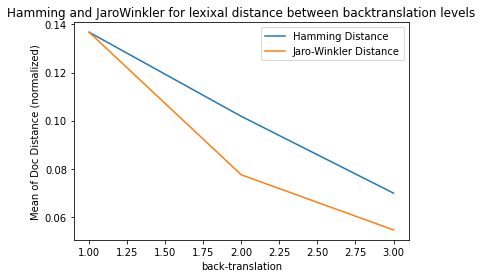

In [ ]:
#values taken from the describe method commented out above

# line 1 points
x1 = [1,2,3]
y1 = [0.136735,0.101772,0.069857]
# plotting the line 1 points 
plt.plot(x1, y1, label = "Hamming Distance")
# line 2 points
x2 = [1,2,3]
y2 = [0.136735,0.077469,0.054566]
# plotting the line 2 points 
plt.plot(x2, y2, label = "Jaro-Winkler Distance")
plt.xlabel('back-translation')
# Set the y axis label of the current axis.
plt.ylabel('Mean of Doc Distance (normalized)')
# Set a title of the current axes.
plt.title('Hamming and JaroWinkler for lexixal distance between backtranslation levels')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

# (Table)

In [ ]:
#total RAM (at 50dim, 80 maxlength, train at 20k, exlcuding KNN) is : 25.6GB
#total RAM (at 50dim, 80 maxlength, train at 20k, exlcuding KNN pretrained models) is : 27GB
#total RAM (at 50dim, 80 maxlength, train at 20k) is 29.5GB:

| Algorithm | Vectorizer | N0 | N1 | N2 | N3 |
| --- | --- | --- | --- | --- | --- |
| Logistic Regression | BoW | .843 | .843 |  .843 |  .843 |
| Logistic Regression | HV | .843 | .843 |  .843 |  .843 |
| Logistic Regression | TFIDF | .843 | .843 |  .843 |  .843 |
| Logistic Regression | GloVe | .843 | .843 |  .843 |  .843 |
| Logistic Regression | w2v | .843 | .843 |  .843 |  .843 |
| Logistic Regression | FastText | .843 | .843 |  .843 |  .843 |
| Naive Bayes | BoW | .843 | .843 |  .843 |  .843 |
| Naive Bayes | HV | .843 | .843 |  .843 |  .843 |
| Naive Bayes | TFIDF | .843 | .843 |  .843 |  .843 |
| Naive Bayes | GloVe | .843 | .843 |  .843 |  .843 |
| Naive Bayes | w2v | .843 | .843 |  .843 |  .843 |
| Naive Bayes | FastText | .843 | .843 |  .843 |  .843 |
| Random Forest | BoW | .843 | .843 |  .843 |  .843 |
| Random Forest | HV | .843 | .843 |  .843 |  .843 |
| Random Forest | TFIDF | .843 | .843 |  .843 |  .843 |
| Random Forest | GloVe | .843 | .843 |  .843 |  .843 |
| Random Forest | w2v | .843 | .843 |  .843 |  .843 |
| Random Forest | FastText | .843 | .843 |  .843 |  .843 |
| etc | etc | .843 | .843 |  .843 |  .843 |
